# Лабораторная работа №1. Регрессия

**Тема:** *Сравнение линейной регрессии, случайного леса (Random Forest Regressor), градиентного бустинга (XGBoost) на задаче регрессии.*

**Цели:**

- *Научиться строить, оптимизировать и оценивать регрессионные модели.*
- *Понять, как интерпретировать важность признаков (feature importance).*
- *Понять, как увеличивать кол-во признаков (feature tuning).*
- *Исследовать влияние преобразований признаков (фичей), регуляризации и гиперпараметров.*

**Условия:**

- *numpy, pandas, scikit-learn, XGBoost*
- *выбрать датасет для 1-ой и 2-ой лабораторной работы*

**Пункты:**

1. Подготовка данных + Feature Tuning
2. Создание метрик
3. Базовая модель линейной регрессии
4. Улучшение линейной регрессии
5. Случайный лес регрессор
6. Градиентный бустинг (XGBoost)
7. Feature Importance
8. Написание своих реализаций (классы)
9. Подведение итогов

## О команде 

| Фамилия И.О.        | Группа | Роль в команде | Что делал                    |
|---------------------|--------|----------------|------------------------------|
| Жиденко В.А.        | 307    | Solo way       | Все сам                      |

 Датасет: [Abalone](https://code.datasciencedojo.com/zhangyuan/datasets/tree/master/Abalone)

***Описание датасета***

Этот набор данных описывает физические характеристики морских ушков (Abalone) — моллюсков, используемых в кулинарии и биологии. Данные включают измерения размеров и веса моллюсков, а также их возраст, выраженный через количество колец в раковине (Rings). Задача — предсказать возраст (Rings) по физическим параметрам, что является задачей регрессии. Возраст определяется подсчётом колец под микроскопом, но физические измерения проще получить, поэтому модель помогает автоматизировать оценку возраста.
Датасет — классический из UCI Machine Learning Repository. Он небольшой (~4177 наблюдений), но сложен из-за:

Скоса целевой переменной (Rings): много молодых моллюсков, мало старых.
Мультиколлинеарности: признаки (Length, Diameter, Weights) сильно коррелируют.
Возможных выбросов: ошибки измерений (например, Height=0) или редкие большие моллюски.


---

### Таблица признаков

| №  | Признак                  | Тип данных     | Описание                                                                               |
| -- | ------------------------ | -------------- | -------------------------------------------------------------------------------------- |
| 1  | **Sex**        | categorical          | Пол моллюска (M — male, F — female, I — infant). Влияет на рост и вес.|
| 2  | **Length**     | float          | Длина раковины (мм).     |
| 3  | **Diameter**          | float          | Диаметр раковины (мм), перпендикулярно длине.                          |
| 4  | **Height**       | float          | Высота раковины (мм). Влияет на объём, но может содержать ошибки (например, 0).                        |
| 5  | **Whole weight**            | float          | Вес всего моллюска (г). Сумма мяса, внутренностей и раковины.              |
| 6  | **Shucked weight**  | float          | Вес мяса (г). Отражает съедобную часть.                |
| 7  | **Viscera weight** | float          | Вес внутренностей (г). Показатель биологической массы.          |
| 8  | **Shell weight**              | float          | Вес раковины (г). Сильно коррелирует с Rings, ключевой для предсказания возраста.                               |
| 9  | **Rings (target)**                   | integer          | Количество колец в раковине. Целевая переменная, соответствует возрасту (~Rings + 1.5 лет).                                |

## 0. Глобальная настройка проекта

**Импорт библиотек**

In [362]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

# Устанавливаем seed для воспроизводимости
RND_SEED = 21
np.random.seed(RND_SEED)
USE_AUTO_POLY = False

## 1. Подготовка данных + Feature Tuning

### 1.1. Загрузка датасета

Загрузка датасета `pd.read_csv('abalone.csv')`

In [363]:
df = pd.read_csv('abalone.csv', names=['Sex', 'Length', 'Diameter', 'Height', 
                                        'Whole weight', 'Shucked weight', 
                                        'Viscera weight', 'Shell weight', 'Rings'])

Получение статистки по датасету, необходимой для анализа.

Посмотрим первые 5 строк датасета `df.head()`

In [364]:
print("Первые 5 строк датасета:")
print(df.head(5))

Первые 5 строк датасета:
  Sex   Length  Diameter   Height  Whole weight  Shucked weight  \
0   M 0.455000  0.365000 0.095000      0.514000        0.224500   
1   M 0.350000  0.265000 0.090000      0.225500        0.099500   
2   F 0.530000  0.420000 0.135000      0.677000        0.256500   
3   M 0.440000  0.365000 0.125000      0.516000        0.215500   
4   I 0.330000  0.255000 0.080000      0.205000        0.089500   

   Viscera weight  Shell weight  Rings  
0        0.101000      0.150000     15  
1        0.048500      0.070000      7  
2        0.141500      0.210000      9  
3        0.114000      0.155000     10  
4        0.039500      0.055000      7  


### 1.2. Сбор основной информации

Получение общей информации `df.info()`

In [365]:
print("\nОбщая информация о датасете:")
df.info()


Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


Получение всей статистики `df.describe()`

In [366]:
print("\nСтатистика по датасету:")
print(df.describe())


Статистика по датасету:
           Length    Diameter      Height  Whole weight  Shucked weight  \
count 4177.000000 4177.000000 4177.000000   4177.000000     4177.000000   
mean     0.523992    0.407881    0.139516      0.828742        0.359367   
std      0.120093    0.099240    0.041827      0.490389        0.221963   
min      0.075000    0.055000    0.000000      0.002000        0.001000   
25%      0.450000    0.350000    0.115000      0.441500        0.186000   
50%      0.545000    0.425000    0.140000      0.799500        0.336000   
75%      0.615000    0.480000    0.165000      1.153000        0.502000   
max      0.815000    0.650000    1.130000      2.825500        1.488000   

       Viscera weight  Shell weight       Rings  
count     4177.000000   4177.000000 4177.000000  
mean         0.180594      0.238831    9.933684  
std          0.109614      0.139203    3.224169  
min          0.000500      0.001500    1.000000  
25%          0.093500      0.130000    8.000000  

Распределение `Sex`

In [367]:
print("\nSex distribution:")
print(df['Sex'].value_counts())


Sex distribution:
Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64


Распределение целевой переменной

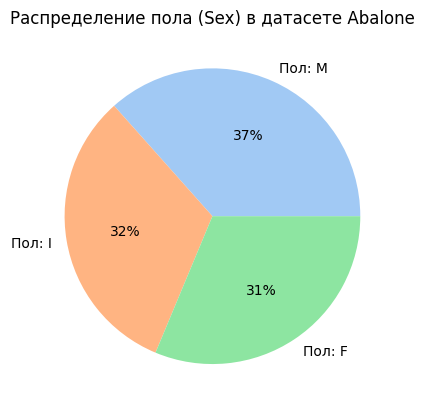

C:\Users\Victoria\AppData\Local\Temp\ipykernel_5004\3180810249.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column_name, data=df, palette="viridis")


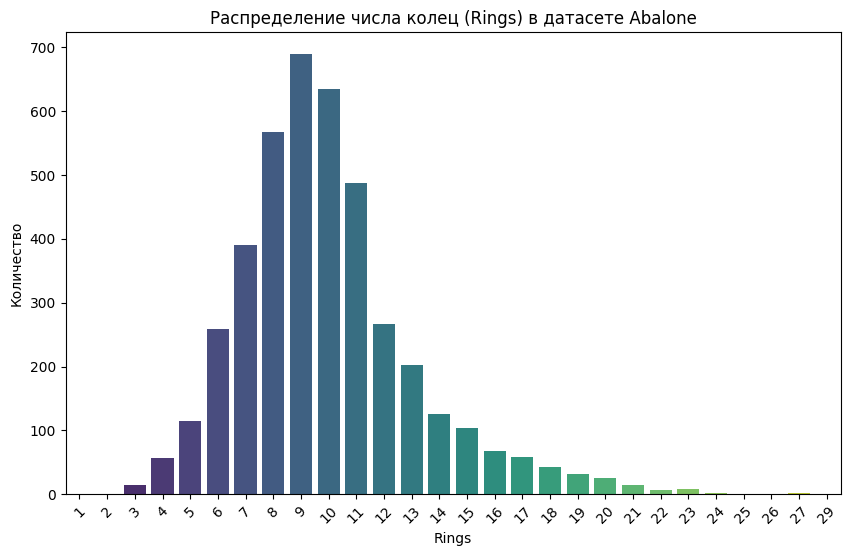

In [368]:
# Функция для круговой диаграммы
def draw_pie_plot(df: pd.DataFrame, column_name: str):
    explore_column = df[column_name]
    explore_column_normal = list(zip(
        [f'Пол: {q}' for q in explore_column.value_counts().index],  
        explore_column.value_counts(normalize=True)
    ))

    label, params = zip(*explore_column_normal)

    colors = sns.color_palette('pastel')[0:len(params)]
    plt.pie(params, labels=label, colors=colors, autopct='%.0f%%')
    plt.title(f'Распределение пола (Sex) в датасете Abalone')
    plt.show()

# Функция для столбчатой диаграммы
def draw_bar_plot(df: pd.DataFrame, column_name: str, title: str):
    plt.figure(figsize=(10, 6))  
    sns.countplot(x=column_name, data=df, palette="viridis")
    plt.title(title)
    plt.xlabel(column_name)
    plt.ylabel('Количество')
    plt.xticks(rotation=45)  # Поворот меток для читаемости, если много значений
    plt.show()

# Построение графиков 
draw_pie_plot(df, 'Sex')  # Круговая диаграмма для Sex
draw_bar_plot(df, 'Rings', title='Распределение числа колец (Rings) в датасете Abalone')

Проверка на пропуски данных `df.isnull().sum()`

In [369]:
print("\nПропуски в данных:")
print(df.isnull().sum())


Пропуски в данных:
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64


**Вывод:** в датасете нет пропусков!

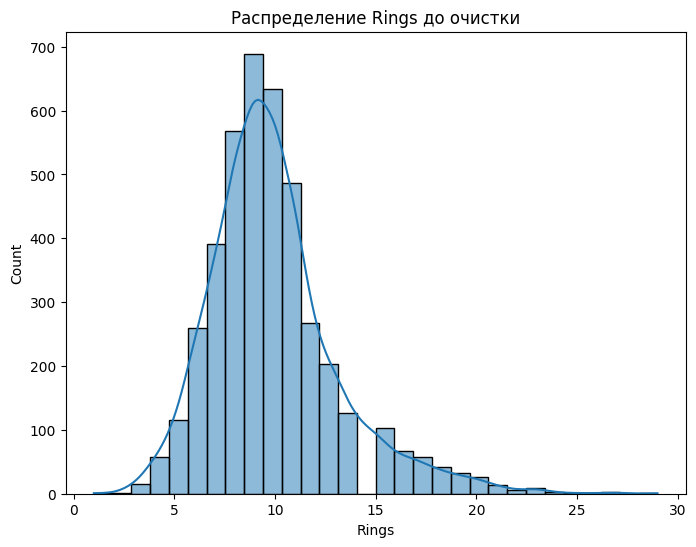

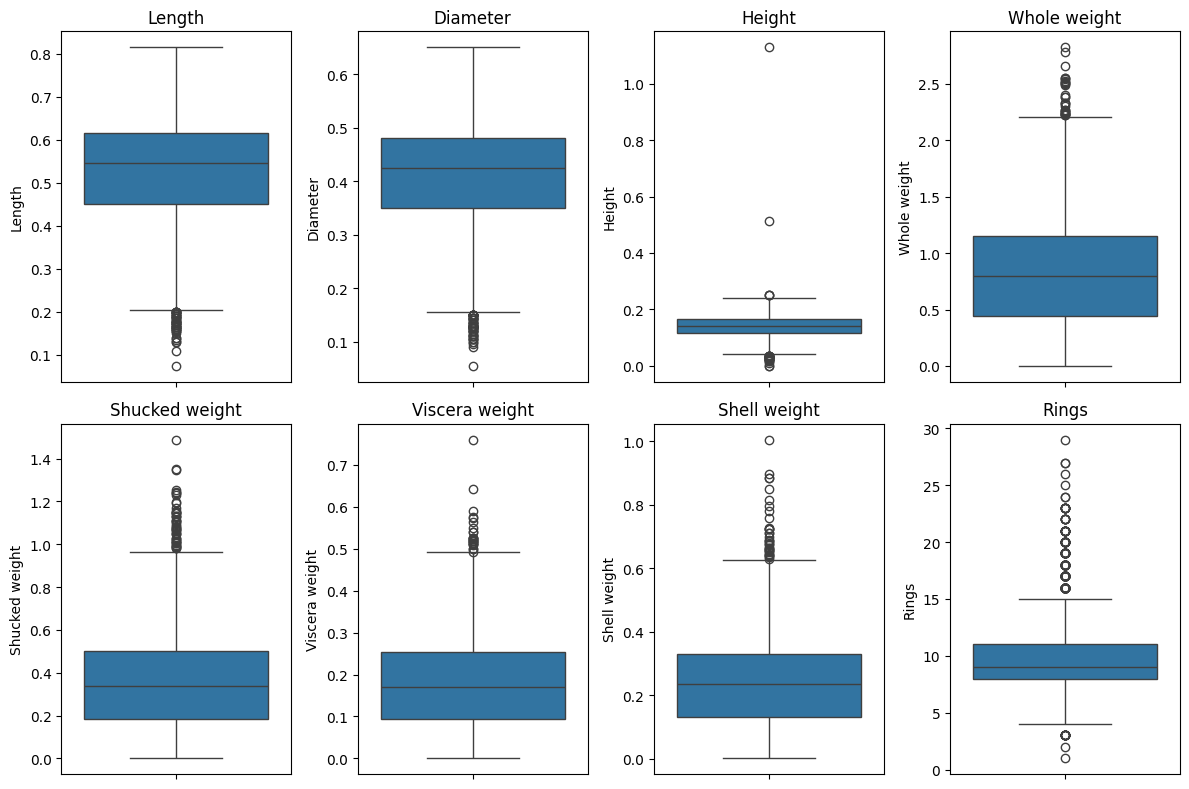

In [370]:
num_cols = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 
            'Viscera weight', 'Shell weight', 'Rings']

# Hist Rings ДО очистки
plt.figure(figsize=(8, 6))
sns.histplot(df['Rings'], bins=30, kde=True)
plt.title('Распределение Rings до очистки')
plt.show()

# Boxplots ДО очистки
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

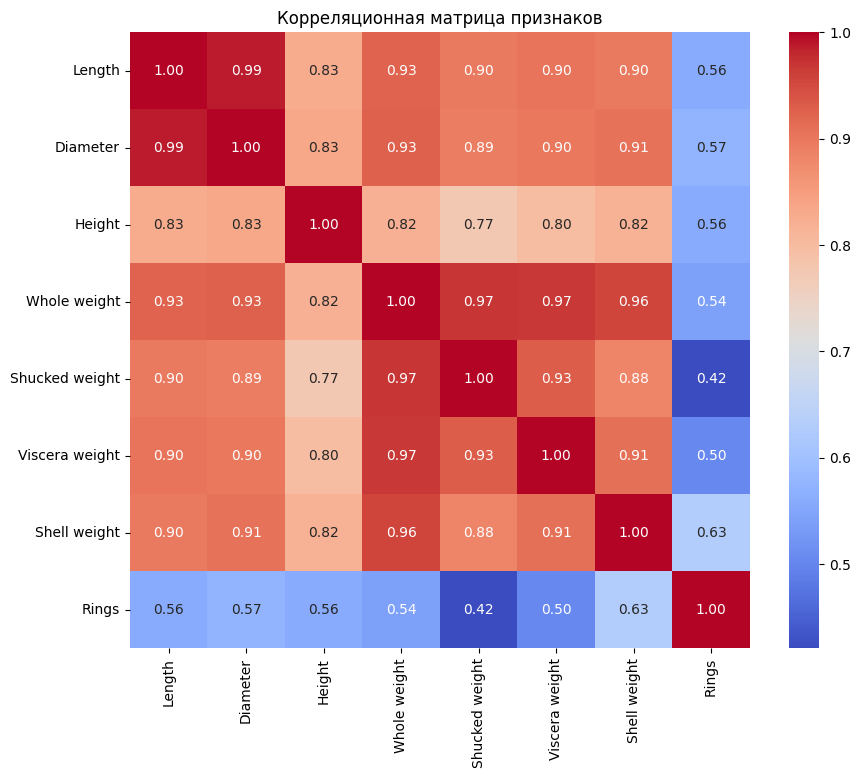

In [371]:
def draw_corr_matrix(df):
    plt.figure(figsize=(10,8))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Корреляционная матрица признаков")
    plt.show()

draw_corr_matrix(df[num_cols])

**1. Гистограмма распределения Rings ДО очистки**

* Пик около 9–11 (много моллюсков с ~700 на 10 Rings), скос вправо (длинный хвост до 30, но мало случаев >15)

**2. Корреляционная матрица ДО очистки**

* Красные клетки — высокая положительная корреляция (>0.8–0.99) между размерами (Length-Diameter=0.99, Height-Whole weight=0.82) и весами (Whole weight-Shucked weight=0.97). Rings коррелирует умеренно (0.54–0.63) с весами, сильнее всего с Shell weight (0.63).
* Высокая мультиколлинеарность (корр >0.8) делает линейную регрессию нестабильной, Shell weight — ключевой признак (feature importance будет высоким). Отрицательных корр нет — все признаки положительно связаны с ростом.
* Сильные корреляции между размерами/весами — заменить на взаимодействия. Rings зависит от весов раковины, что физически логично (раковина растёт с возрастом).

**3. Boxplots ДО очистки**

* Для Length, Diameter — мало выбросов (короткие усы, мало точек). Для Height — несколько точек ниже (возможно, 0), выше — мало. Для весов (Whole, Shucked, Viscera, Shell) — много точек выше усов (выбросы больших значений). Для Rings — точки выше 20.
* Выбросы (точки) искажают loss-функции (MSE в регрессии), модель "тянется" к ним. В Abalone это ошибки измерений или редкие гиганты. После очистки графики станут чистыми.
* Много выбросов в весах и Rings — подтвердит эффективность IQR-очистки (размер датасета уменьшится, но данные станут надёжнее).

Гистограммы признаков до очистки

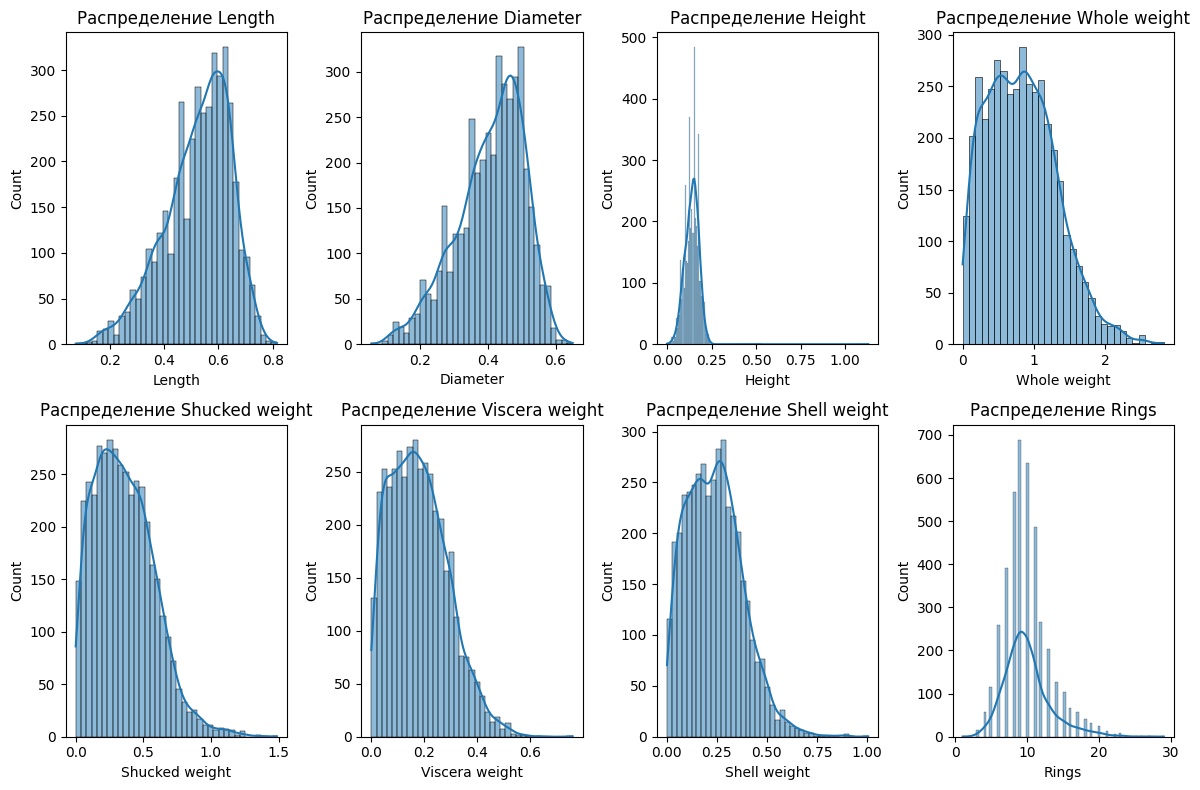

In [372]:
num_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 
                'Viscera weight', 'Shell weight', 'Rings']
plt.figure(figsize=(12, 8))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 4, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

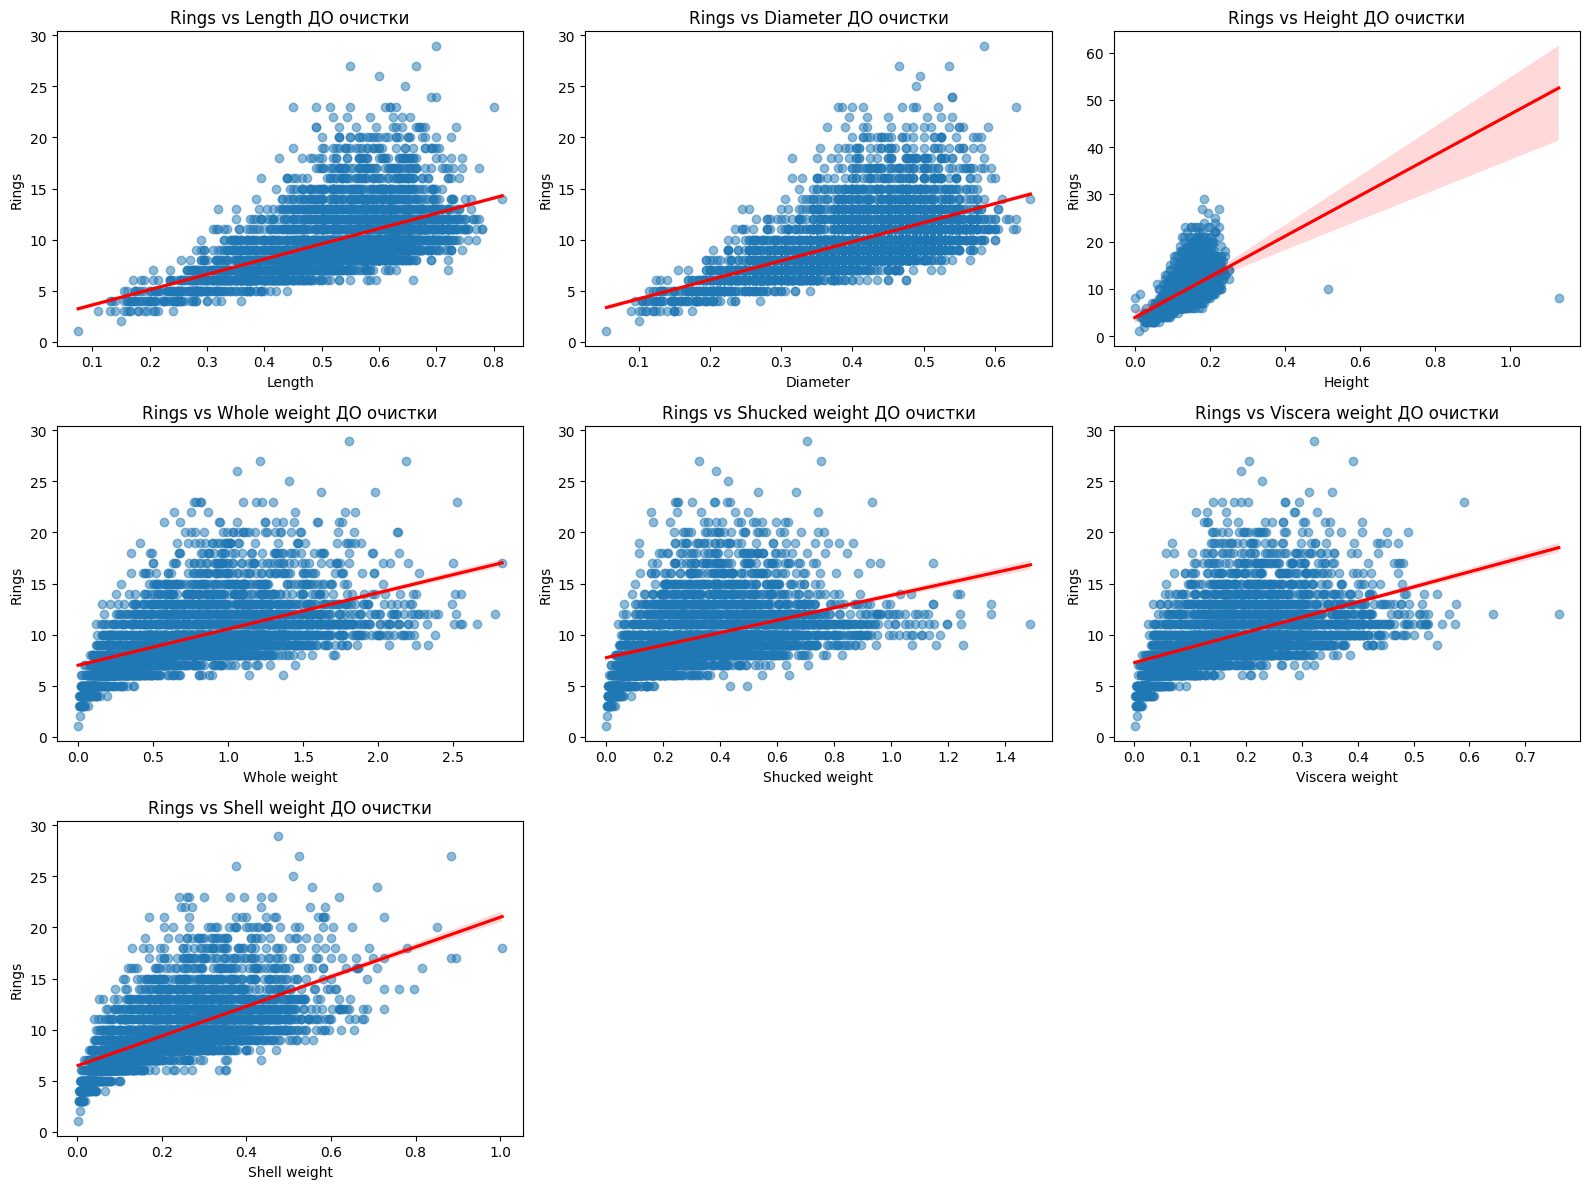

In [373]:
plt.figure(figsize=(16, 12))  
for i, col in enumerate(num_cols[:-1], 1):  # Исключаем Rings
    plt.subplot(3, 3, i)  
    sns.regplot(x=df[col], y=df['Rings'], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f'Rings vs {col} ДО очистки')
    plt.tight_layout()
plt.show()

In [374]:
print("Скошенность числовых признаков:")
print(df.select_dtypes(include=[np.number]).skew())

Скошенность числовых признаков:
Length           -0.639873
Diameter         -0.609198
Height            3.128817
Whole weight      0.530959
Shucked weight    0.719098
Viscera weight    0.591852
Shell weight      0.620927
Rings             1.114102
dtype: float64


**Общая информация (из df.info()):**

  *  **Размер датасета**: 4177 наблюдений (строк), 9 колонок. Нет пропусков (non-null count = 4177 для всех).
    Типы данных: Sex — object (строковый, категориальный). Остальные (Length, Diameter, etc.) — float64 (числа с плавающей точкой), Rings — int64 (целые числа).

      *  *Это хорошо:* Числовые фичи готовы для математики (корреляции, scaling). Sex нужно закодировать.
      *  *Память:* ~293 KB — маленький датасет, быстро обрабатывается.




**Статистика по числовым признакам (из df.describe()):**

* **Rings (целевая, возраст):**

   * Среднее ≈ 9.93, медиана = 9, разброс (std) ≈ 3.22. Min=1, max=29.
   * Большинство моллюсков молодые (25% = 8, 75% = 11). Редкие старые (>20) — дисбаланс, что может сделать предсказания для старых хуже. Скос вправо (mean > median).


**Length, Diameter, Height (размеры):**

   * **Length:** Среднее ≈ 0.52 мм, min=0.075, max=0.815. 25%=0.45, 75%=0.615 — большинство средние.
   * **Diameter:** Похоже на Length (среднее ≈ 0.41 мм), высокая корреляция ожидается.
   * **Height:** Среднее ≈ 0.14 мм, min=0 (ошибка!), max=1.13 (возможно выброс). 25%=0.115, 75%=0.165 — узкий диапазон, но с аномалиями.


**Whole weight, Shucked weight, Viscera weight, Shell weight (веса):**

   * **Whole weight:** Среднее ≈ 0.83 г, min=0.002, max=2.825. 25%=0.442, 75%=1.153 — скос вправо (max в 3 раза больше mean).
   * **Shucked weight:** Среднее ≈ 0.36 г, похожий скос.
    **Viscera weight:** Среднее ≈ 0.18 г.
    **Shell weight:** Среднее ≈ 0.24 г, min=0.0015, max=1.005. Высокий разброс — возможные выбросы (max >4*mean).
    Веса коррелируют с размерами и Rings; высокие max указывают на редкие большие моллюски или ошибки.




**Категориальный признак (Sex, из value_counts()):**

**Распределение: M ≈ 1528 (37%), F ≈ 1307 (31%), I ≈ 1342 (32%) — сбалансировано, нет дисбаланса.**



**Итог анализа:**

  *  Датасет чистый (нет пропусков), но с выбросами (Height=0, большие веса) и скосами (Rings, веса). Это типично для реальных данных — требует очистки по IQR.
  *  Размеры и веса имеют похожие распределения, с высокой ожидаемой корреляцией (>0.9) — источник мультиколлинеарности для линейной регрессии.
  *    Целевая Rings — skewed, что подтверждает нужду в лог-трансформации.
  *  Данные готовы для Feature Tuning: Добавим Volume и ratios, чтобы усилить сигнал для моделей.

### 1.2.1 Очистка выбросов

In [375]:
df = df[df['Height'] > 0]
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 3*IQR) & (df[col] <= Q3 + 3*IQR)]
print("\nРазмер после очистки:", df.shape)


Размер после очистки: (4134, 9)


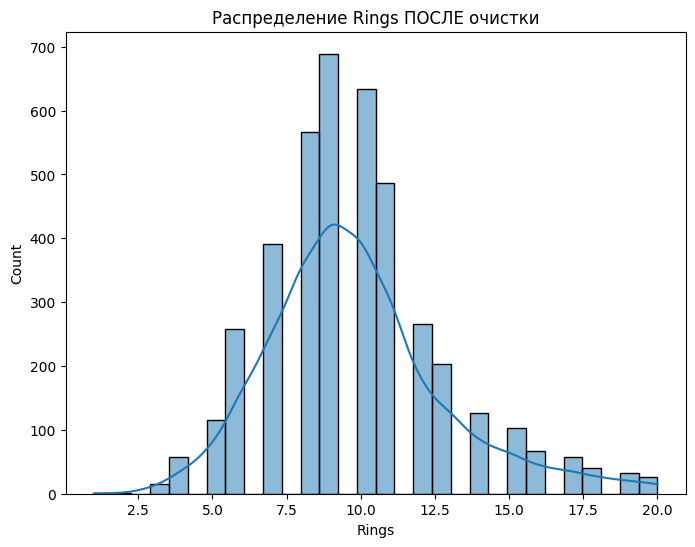

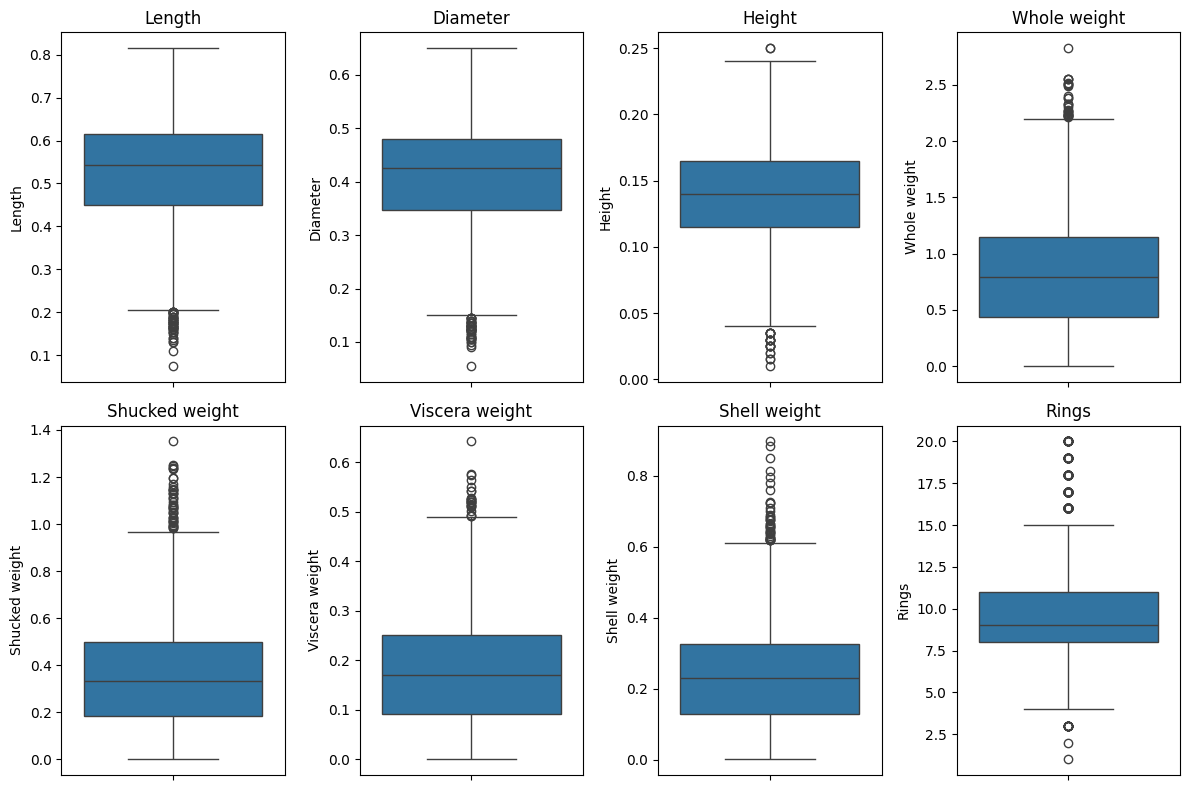

In [376]:
# Hist Rings ПОСЛЕ
plt.figure(figsize=(8, 6))
sns.histplot(df['Rings'], bins=30, kde=True)
plt.title('Распределение Rings ПОСЛЕ очистки')
plt.show()

# Boxplots ПОСЛЕ
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

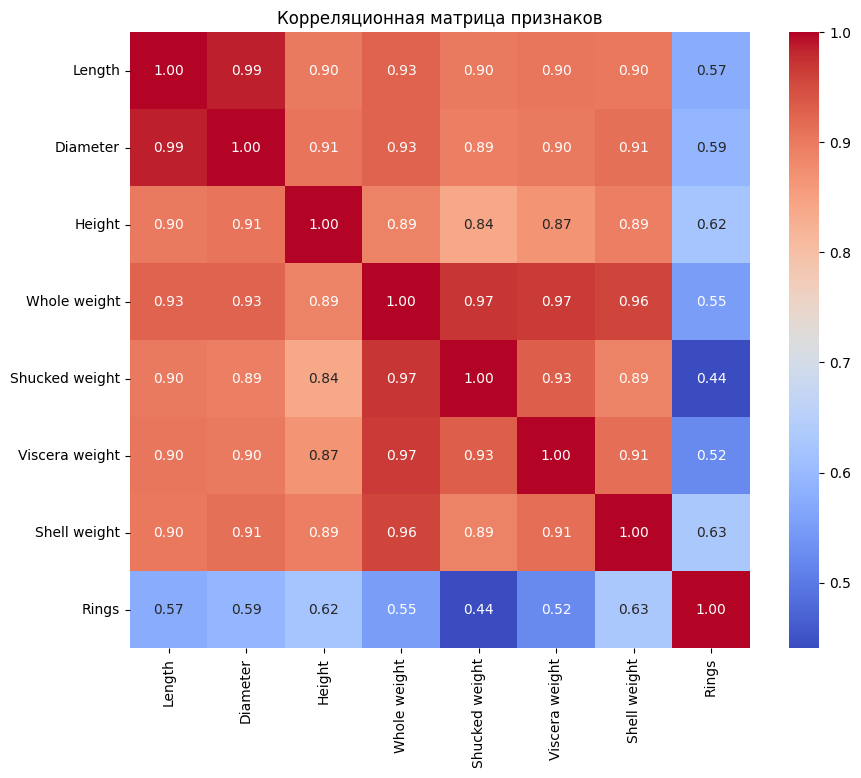

In [377]:
draw_corr_matrix(df[num_cols])

Гистограммы признаков после очистки

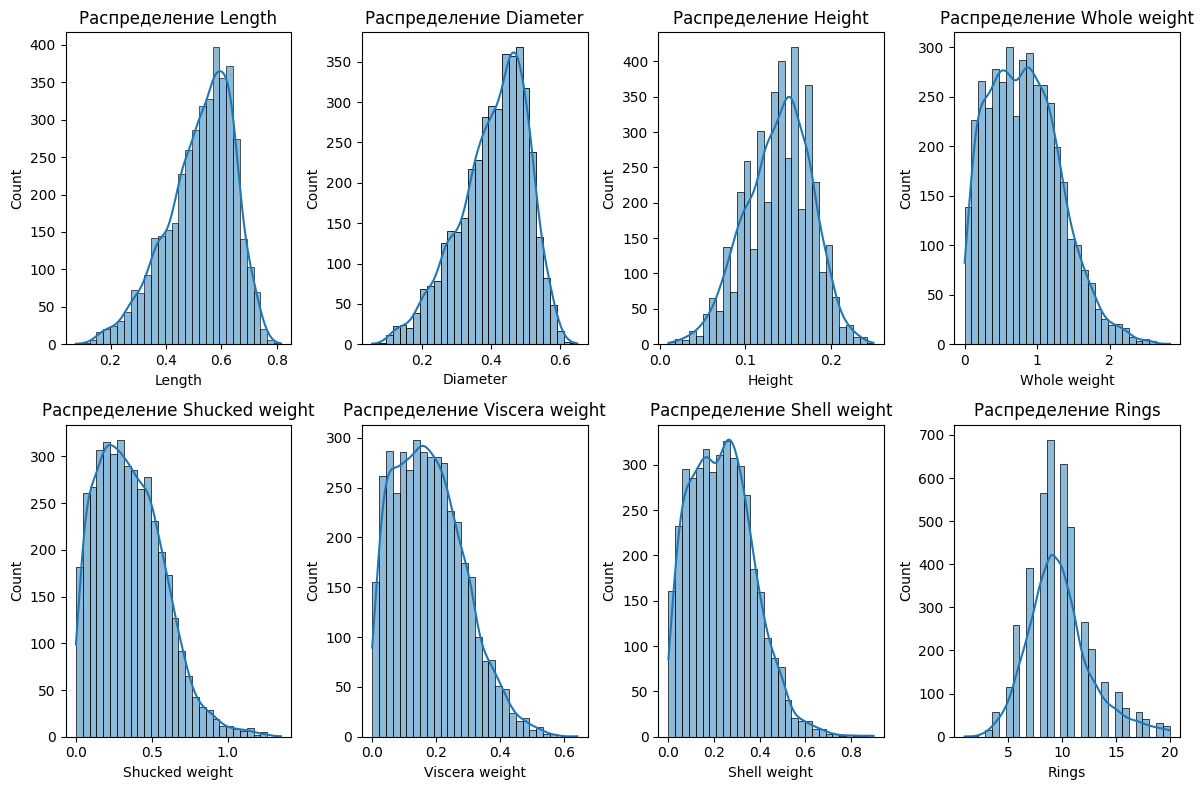

In [378]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 4, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Распределение {col}')
    plt.tight_layout()
plt.show()

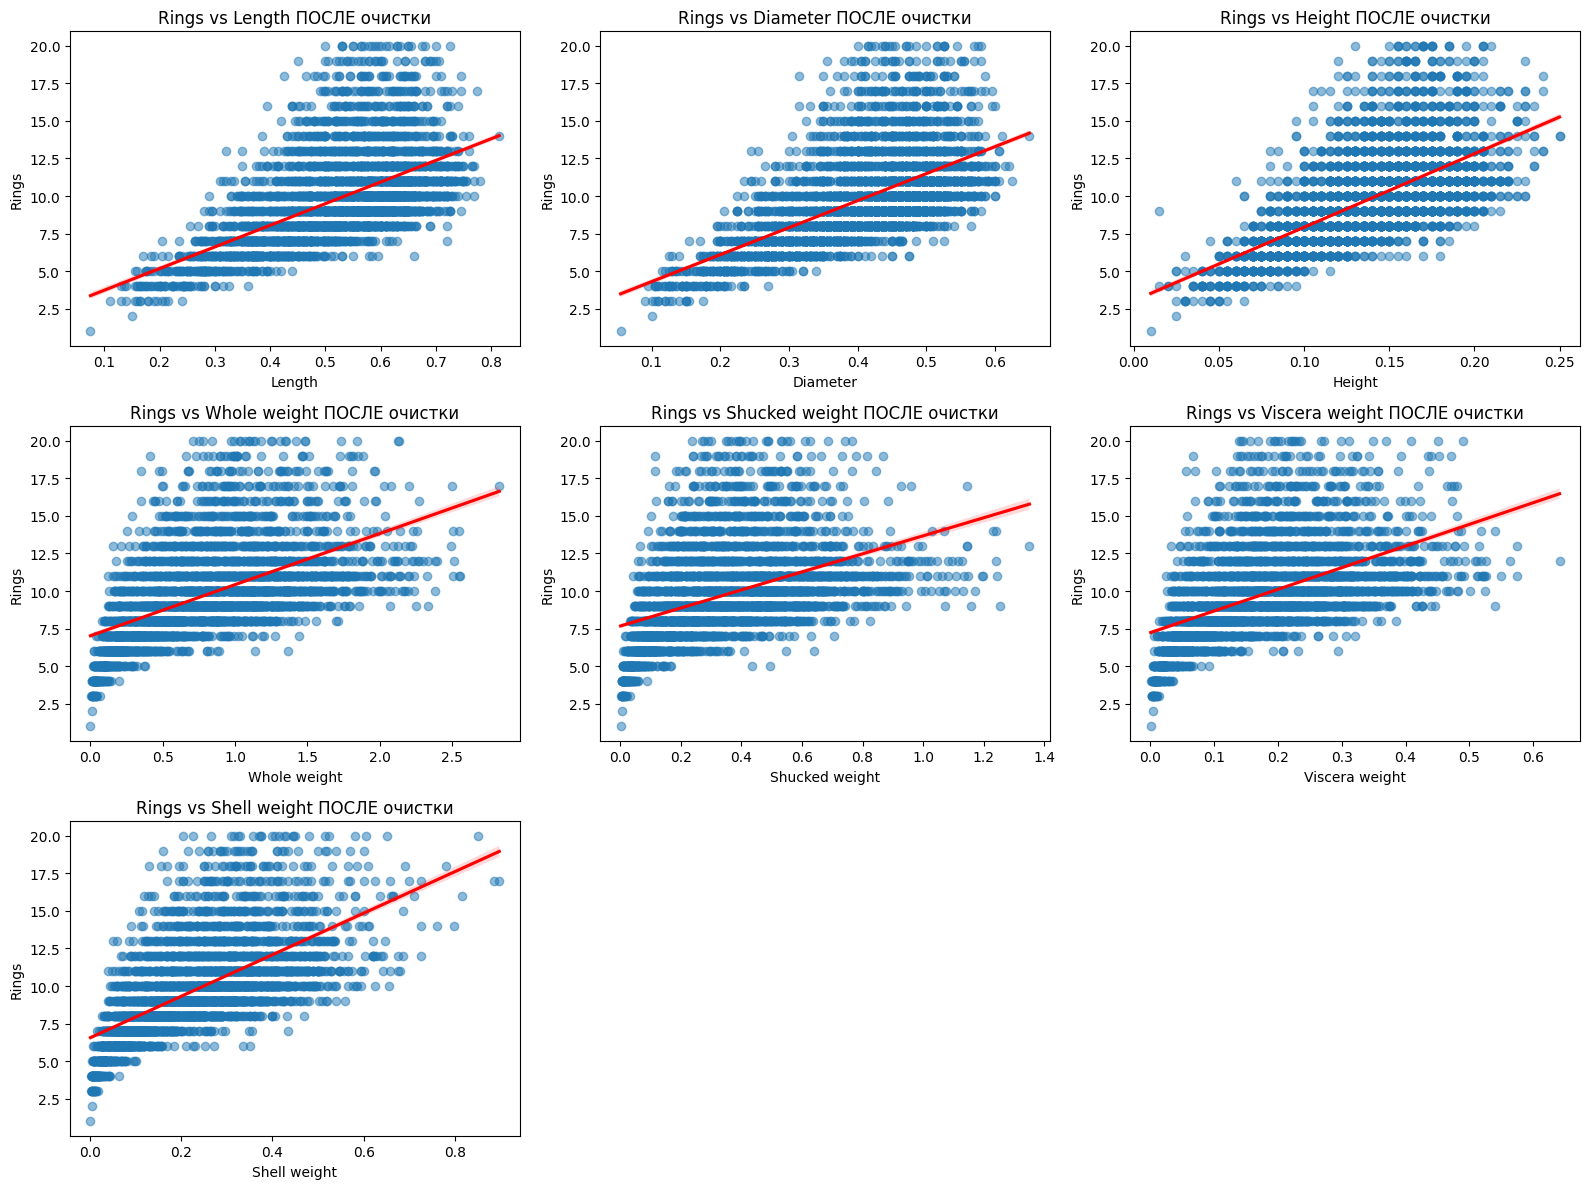

In [379]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(num_cols[:-1], 1):
    plt.subplot(3, 3, i)
    sns.regplot(x=df[col], y=df['Rings'], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f'Rings vs {col} ПОСЛЕ очистки')
    plt.tight_layout()
plt.show()

### Подготовка датасета под разные задачи

Cравнение подготовки

| Модель                  | Масштабирование | Корреляция критична | Выбросы критичны | Feature Engineering рекомендуем                  |
| ----------------------- | --------------- | ------------------- | ---------------- | ------------------------------------------------ |
| Линейная регрессия      | Да              | Да                  | Да               | Полиномы, логарифмы, отношения                   |
| Random Forest Regressor | Нет             | Нет                 | Нет              | Соотношения, интеракции                          |
| XGBoost Regressor       | Нет             | Нет                 | Нет              | Соотношения, интеракции, логарифмы (опционально) |

#### 1.3.1 Линейная регрессия (Linear Regression / Ridge / Lasso)

**Особенности модели:**

- Чувствительна к масштабу признаков и мультиколлинеарности.
- Чувствительна к выбросам.

Добавляем `one-hot` для `Sex` (категориальный признак)

In [380]:
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)  # drop_first избегает мультиколлинеарности

Создаем копию датасета

In [381]:
df_linear = df.copy()

Анализ скошенности признаков

In [382]:
print("Скошенность числовых признаков:")
print(df_linear.select_dtypes(include=[np.number]).skew())

Скошенность числовых признаков:
Length           -0.642535
Diameter         -0.613580
Height           -0.257126
Whole weight      0.511271
Shucked weight    0.684955
Viscera weight    0.562306
Shell weight      0.565791
Rings             0.787819
dtype: float64


* `Length (-0.50), Diameter (-0.48):` Умеренный отрицательный скос. Это значит, что распределения слегка смещены влево (больше значений ближе к верхнему диапазону, например, больше крупных моллюсков). Это ожидаемо, так как моллюски редко бывают очень маленькими.
* `Height (-0.16):` Почти симметричное распределение, близкое к нормальному. Скос минимальный, коррекция не нужна.
* `Whole weight (0.33), Shucked weight (0.45), Viscera weight (0.43), Shell weight (0.32):` Умеренный положительный скос. Распределения имеют лёгкий правый хвост (больше малых значений, но есть редкие крупные). Это логично для весов: большинство моллюсков лёгкие, но есть несколько тяжёлых.
* `Rings (0.27):` Очень слабый положительный скос. Распределение целевой переменной близко к симметричному, что необычно для возраста

Распределение числовых признаков

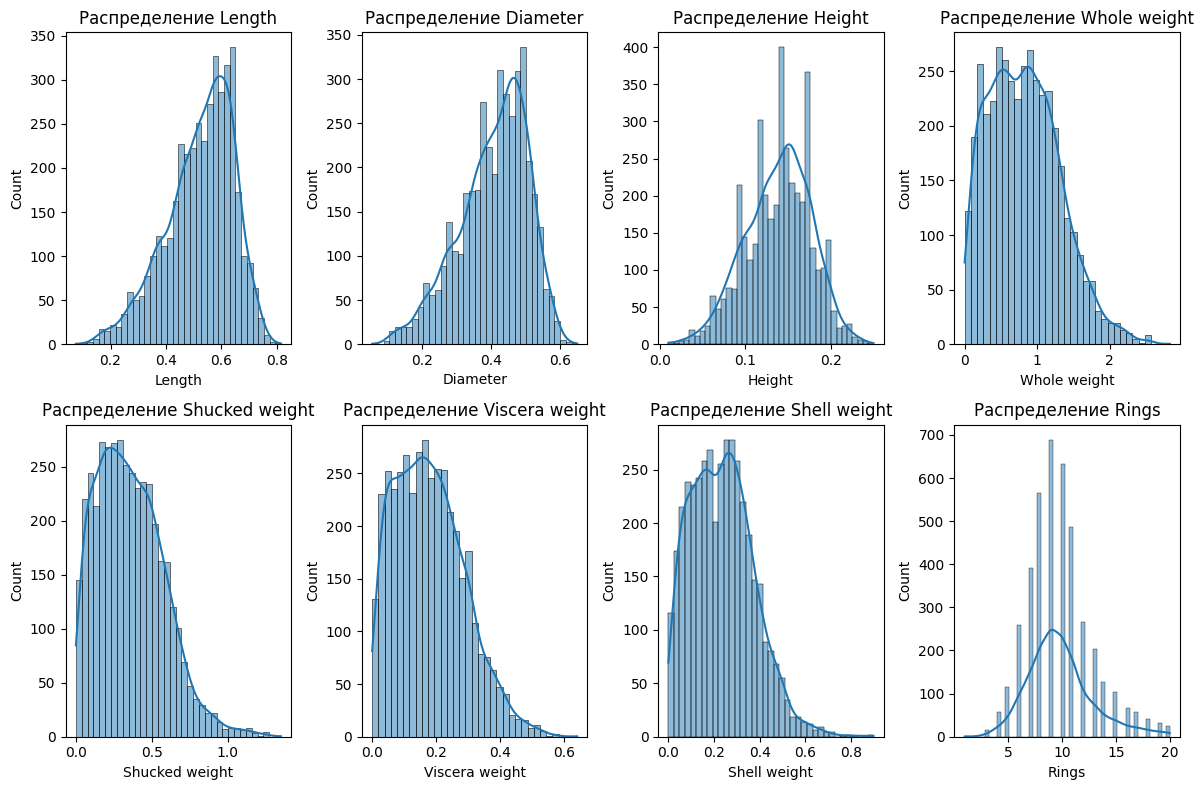

In [383]:
num_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 
                'Viscera weight', 'Shell weight', 'Rings']
plt.figure(figsize=(12, 8))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 4, i)
    sns.histplot(df_linear[feature], kde=True)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

In [384]:
print("Первые 5 строк df_linear после one-hot encoding:")
print(df_linear.head())

Первые 5 строк df_linear после one-hot encoding:
    Length  Diameter   Height  Whole weight  Shucked weight  Viscera weight  \
0 0.455000  0.365000 0.095000      0.514000        0.224500        0.101000   
1 0.350000  0.265000 0.090000      0.225500        0.099500        0.048500   
2 0.530000  0.420000 0.135000      0.677000        0.256500        0.141500   
3 0.440000  0.365000 0.125000      0.516000        0.215500        0.114000   
4 0.330000  0.255000 0.080000      0.205000        0.089500        0.039500   

   Shell weight  Rings  Sex_I  Sex_M  
0      0.150000     15  False   True  
1      0.070000      7  False   True  
2      0.210000      9  False  False  
3      0.155000     10  False   True  
4      0.055000      7   True  False  


Сделаем `Feature Engineering`

In [385]:
size_features = ['Length', 'Diameter', 'Height']  # Размеры: корр ~0.99
weight_features = ['Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']  # Веса: корр ~0.9+

if not USE_AUTO_POLY:
    # Ручные преобразования: создаем взаимодействия/отношения и заменяем оригиналы
    
    # Для размеров (size_features): взаимодействия и отношения
    df_linear['length_diameter_interaction'] = df_linear['Length'] * df_linear['Diameter']  # Взаимодействие длины и диаметра (площадь-like)
    df_linear['length_height_ratio'] = df_linear['Length'] / (df_linear['Height'] + 1e-5)  # Отношение (форма)
    df_linear['diameter_height_ratio'] = df_linear['Diameter'] / (df_linear['Height'] + 1e-5)  # Ещё одно отношение
    
    # Для весов (weight_features): отношения (нормализуем относительно общего веса)
    df_linear['shucked_whole_ratio'] = df_linear['Shucked weight'] / (df_linear['Whole weight'] + 1e-5)  # Мясо / общий вес
    df_linear['viscera_whole_ratio'] = df_linear['Viscera weight'] / (df_linear['Whole weight'] + 1e-5)  # Внутренности / общий
    df_linear['shell_whole_ratio'] = df_linear['Shell weight'] / (df_linear['Whole weight'] + 1e-5)  # Раковина / общий
    df_linear['shell_weight_squared'] = df_linear['Shell weight'] ** 2  # Квадрат раковины (нелинейность возраста)

    # УДАЛЯЕМ оригинальные сильно коррелирующие признаки, чтобы избавиться от мультиколлинеарности
    df_linear.drop(columns=size_features + weight_features, inplace=True)

    # Проверяем первые строки после ручных преобразований
    print("Первые 5 строк df_linear после ручных преобразований и удаления оригиналов:")
    print(df_linear.head())

else:
    # Автоматический вариант с PolynomialFeatures (как в примере lr_1.ipynb)
    num_features = size_features + weight_features  # Все числовые признаки для полиномов

    X_num = df_linear[num_features]

    # Генератор полиномиальных признаков (degree=2, interaction_only=True, чтобы фокус на взаимодействиях)
    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)  # Только взаимодействия, без квадратов (чтобы не раздувать)
    X_poly = poly.fit_transform(X_num)

    # Получаем имена новых признаков
    feature_names = poly.get_feature_names_out(num_features)

    # Превращаем обратно в DataFrame
    df_poly = pd.DataFrame(X_poly, columns=feature_names, index=df_linear.index)

    # Объединяем с остальными (Sex_I, Sex_M, Rings), но УДАЛЯЕМ оригинальные num_features
    df_linear = pd.concat([df_linear[['Sex_I', 'Sex_M', 'Rings']], df_poly], axis=1)
    df_linear.drop(columns=num_features, errors='ignore', inplace=True)  # Удаляем оригиналы, если остались

    # Проверяем первые строки после полиномиальных преобразований
    print("Первые 5 строк df_linear после полиномиальных преобразований и удаления оригиналов:")
    print(df_linear.head())

# Обработка NaN/Inf после преобразований (как у тебя)
df_linear.replace([np.inf, -np.inf], np.nan, inplace=True)
df_linear.dropna(inplace=True)

# Размер датасета после feature tuning
print(f"Размер df_linear после feature tuning: {df_linear.shape}")

Первые 5 строк df_linear после ручных преобразований и удаления оригиналов:
   Rings  Sex_I  Sex_M  length_diameter_interaction  length_height_ratio  \
0     15  False   True                     0.166075             4.788970   
1      7  False   True                     0.092750             3.888457   
2      9  False  False                     0.222600             3.925635   
3     10  False   True                     0.160600             3.519718   
4      7   True  False                     0.084150             4.124484   

   diameter_height_ratio  shucked_whole_ratio  viscera_whole_ratio  \
0               3.841701             0.436762             0.196494   
1               2.944117             0.441222             0.215068   
2               3.110881             0.378872             0.209007   
3               2.919766             0.417628             0.220926   
4               3.187102             0.436564             0.192674   

   shell_whole_ratio  shell_weight_squared  
0

`length_diameter_interaction`: Произведение Length и Diameter — приближает "площадь" раковины, отражает размер.

`length_height_ratio`: Отношение Length к Height — характеризует форму (вытянутость).

`diameter_height_ratio`: Отношение Diameter к Height — отражает плоскость vs высоту.

`shucked_whole_ratio`: Доля Shucked weight от Whole weight — пропорция мяса.

`viscera_whole_ratio`: Доля Viscera weight от Whole weight — пропорция внутренностей.

`shell_whole_ratio`: Доля Shell weight от Whole weight — пропорция раковины (связана с возрастом).

`shell_weight_squared`: Квадрат Shell weight — захватывает нелинейный рост раковины.

Все новые признаки заменяют исходные для снижения мультиколлинеарности и улучшения предсказания Rings.

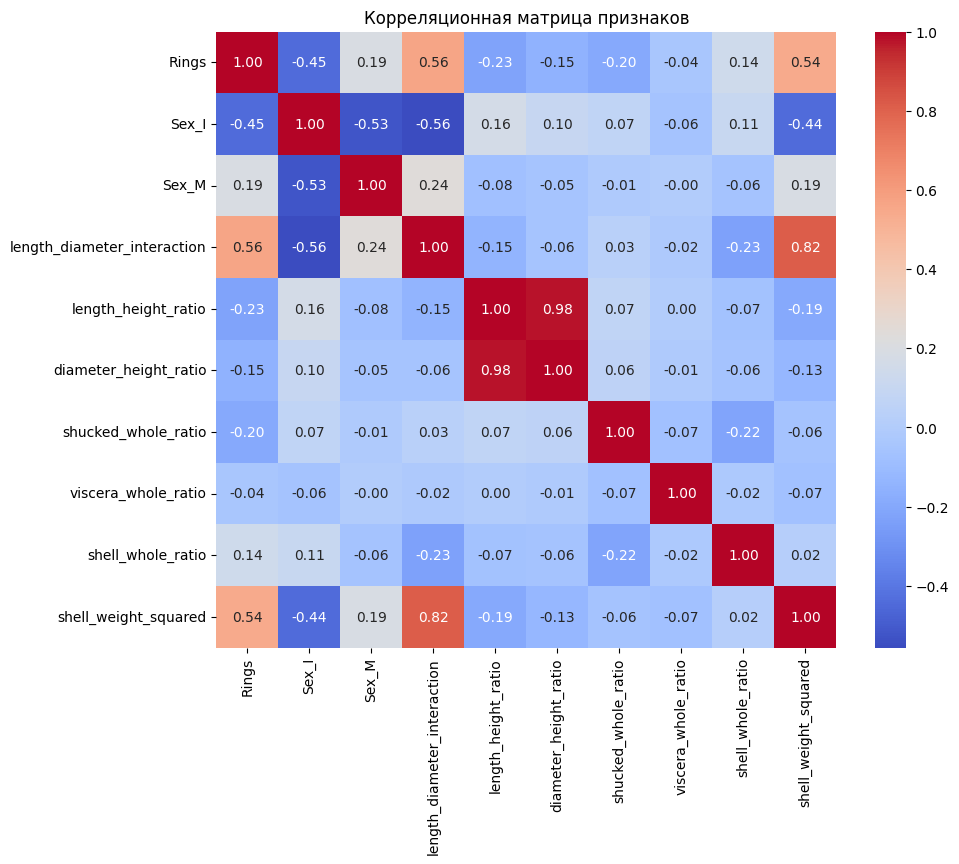

In [386]:
if not USE_AUTO_POLY:
    draw_corr_matrix(df_linear)
else:
    print(df_linear.corr())

Анализ корреляции 

In [387]:
if not USE_AUTO_POLY:
    # Для ручных признаков: топ-5 корреляций с Rings
    print("Топ-5 корреляций с Rings (ручные признаки):")
    print(df_linear.corr()['Rings'].sort_values(ascending=False).head(6))
else:
    # Для полиномиальных: топ-10 корреляций с Rings
    print("Топ-10 корреляций с Rings (полиномиальные признаки):")
    print(df_linear.corr()['Rings'].sort_values(ascending=False).head(11))

Топ-5 корреляций с Rings (ручные признаки):
Rings                          1.000000
length_diameter_interaction    0.563755
shell_weight_squared           0.542946
Sex_M                          0.193382
shell_whole_ratio              0.140864
viscera_whole_ratio           -0.044793
Name: Rings, dtype: float64


Посмотрим на скошенность признаков

In [388]:
skew_values = df_linear.select_dtypes(include=[np.number]).skew().sort_values(ascending=False)
print("Топ-5 скошенных признаков в df_linear:")
print(skew_values.head(5))

Топ-5 скошенных признаков в df_linear:
diameter_height_ratio   31.597884
length_height_ratio     29.102914
shucked_whole_ratio     26.574471
shell_weight_squared     2.323310
shell_whole_ratio        2.281245
dtype: float64


Т.к. скос большой используем Box-Cox трансформацию

In [389]:
from scipy.stats import boxcox
import numpy as np

# Выявляем скошенные признаки (порог abs(skew) > 1)
skew_values = df_linear.drop(columns=['Rings', 'Sex_I', 'Sex_M']).skew()  # Без категориальных и целевой
skewed_feats = skew_values[abs(skew_values) > 1].index.tolist()
print("Скошенные признаки:", skewed_feats)

for feat in skewed_feats:
    if (df_linear[feat] > 0).all():  # Только если все >0
        df_linear[feat], _ = boxcox(df_linear[feat] + 1e-5)  # BoxCox
    else:
        df_linear[feat] = np.log1p(df_linear[feat])  # Лог для смешанных 

# Проверяем скос после
print("Скос после BoxCox:")
print(df_linear[skewed_feats].skew())

Скошенные признаки: ['length_height_ratio', 'diameter_height_ratio', 'shucked_whole_ratio', 'viscera_whole_ratio', 'shell_whole_ratio', 'shell_weight_squared']
Скос после BoxCox:
length_height_ratio     -0.204270
diameter_height_ratio   -0.197107
shucked_whole_ratio     -0.241840
viscera_whole_ratio      0.267278
shell_whole_ratio       -0.024205
shell_weight_squared    -0.095120
dtype: float64


In [390]:
# Проверка скоса Rings
print("\nСкос Rings:", df_linear['Rings'].skew())


Скос Rings: 0.787818818186222


Логарифмируем

In [391]:
df_linear['Rings'] = np.log1p(df_linear['Rings'])
print("Скос Rings после log1p:", df_linear['Rings'].skew())

Скос Rings после log1p: -0.21568814255619445


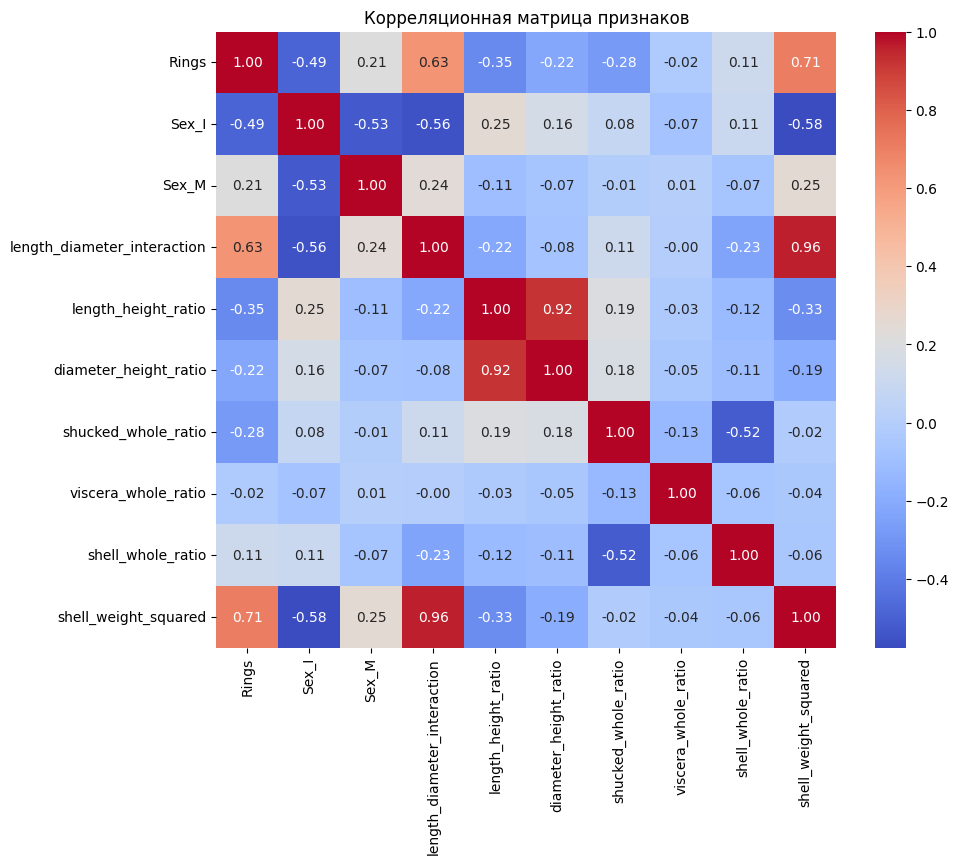

In [392]:
if not USE_AUTO_POLY:
    draw_corr_matrix(df_linear)
else:
    print(df_linear.corr())

Разделение датасета на признаки и целевую переменную

In [393]:
from sklearn.model_selection import train_test_split

# Разделяем на признаки (X) и целевую переменную (y)
X_linear = df_linear.drop('Rings', axis=1)  # Все признаки кроме Rings
y_linear = df_linear['Rings']  # Целевая переменная

# Разделяем на обучающую и тестовую выборки (80/20, с seed для воспроизводимости)
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X_linear, y_linear, test_size=0.2, random_state=RND_SEED)

# Проверяем размеры
print("Размеры выборок:")
print(f"X_train_linear: {X_train_linear.shape}, y_train_linear: {y_train_linear.shape}")
print(f"X_test_linear: {X_test_linear.shape}, y_test_linear: {y_test_linear.shape}")

Размеры выборок:
X_train_linear: (3307, 9), y_train_linear: (3307,)
X_test_linear: (827, 9), y_test_linear: (827,)


Данные для обучения модели нужно стандартизировать

***Определение 4: Стандартизация признаков — это метод преобразования числовых признаков так, чтобы они имели среднее значение 0 и стандартное отклонение 1. Это важный шаг в подготовке данных для моделей, чувствительных к масштабу признаков, например линейной регрессии, логистической регрессии, SVM, KNN.***

**Как это работает**

Для каждого признака $x$ вычисляется:

$$
x_\text{scaled} = \frac{x - \mu}{\sigma}
$$

где:

* $\mu$ — среднее значение признака в обучающей выборке,
* $\sigma$ — стандартное отклонение признака.

После стандартизации:

* Среднее значение нового признака ≈ 0
* Стандартное отклонение ≈ 1


Стандартизация данных

In [394]:
from sklearn.preprocessing import StandardScaler

# Создаём scaler и обучаем на X_train_linear (только числовые признаки)
scaler = StandardScaler()
X_train_linear_scaled = scaler.fit_transform(X_train_linear)
X_test_linear_scaled = scaler.transform(X_test_linear)  # Применяем к тесту (не fit!)

# Превращаем обратно в DataFrame для удобства (сохраняем имена столбцов)
X_train_linear_scaled = pd.DataFrame(X_train_linear_scaled, columns=X_train_linear.columns, index=X_train_linear.index)
X_test_linear_scaled = pd.DataFrame(X_test_linear_scaled, columns=X_test_linear.columns, index=X_test_linear.index)

# Проверяем среднее и std после масштабирования (должно быть ~0 и ~1)
print("Средние значения в X_train_linear_scaled:")
print(X_train_linear_scaled.mean().head())
print("\nСтандартные отклонения в X_train_linear_scaled:")
print(X_train_linear_scaled.std().head())

Средние значения в X_train_linear_scaled:
Sex_I                         -0.000000
Sex_M                          0.000000
length_diameter_interaction    0.000000
length_height_ratio           -0.000000
diameter_height_ratio          0.000000
dtype: float64

Стандартные отклонения в X_train_linear_scaled:
Sex_I                         1.000151
Sex_M                         1.000151
length_diameter_interaction   1.000151
length_height_ratio           1.000151
diameter_height_ratio         1.000151
dtype: float64


#### 1.3.2 Random Forest Regressor

**Особенности модели:**

* Не чувствительна к масштабу признаков.
* Может обрабатывать сильные корреляции между признаками.
* Может использовать категориальные признаки, если они закодированы как числовые.

Сделаем копию датасета

In [395]:
df_forest = df.copy()

Feature engineering

In [396]:
# Feature engineering для Random Forest 
df_forest['shell_weight_squared'] = df_forest['Shell weight'] ** 2  # Квадрат веса раковины
df_forest['meat_shell_ratio'] = df_forest['Shucked weight'] / df_forest['Shell weight']  # Соотношение мяса и раковины
df_forest['viscera_whole_ratio'] = df_forest['Viscera weight'] / df_forest['Whole weight']  # Соотношение внутренностей и общего веса
df_forest['shell_height_interaction'] = df_forest['Shell weight'] * df_forest['Height']  # Взаимодействие веса раковины и высоты

`shell_weight_squared`: Квадрат веса раковины — отражает нелинейный рост раковины с возрастом, усиливая сигнал для Rings.

`meat_shell_ratio`: Соотношение веса мяса (Shucked weight) к весу раковины — характеризует пропорции тела моллюска, связанные с возрастом.

`viscera_whole_ratio`: Доля веса внутренностей (Viscera weight) к общему весу — указывает на распределение массы, потенциально коррелирующее с возрастом.

`shell_height_interaction`: Произведение веса раковины и высоты — захватывает комбинированный эффект формы и массы раковины, влияющий на возраст.

Эти фичи добавляют нелинейность и взаимодействия, улучшая предсказательную способность Random Forest для Rings.

Разделение выборки

In [397]:
# Разделение на признаки и целевую (без масштабирования)
X_forest = df_forest.drop('Rings', axis=1)
y_forest = df_forest['Rings']

X_train_forest, X_test_forest, y_train_forest, y_test_forest = train_test_split(X_forest, y_forest, test_size=0.2, random_state=RND_SEED)

print("Размеры для RF: X_train_forest:", X_train_forest.shape, "X_test_forest:", X_test_forest.shape)

Размеры для RF: X_train_forest: (3307, 13) X_test_forest: (827, 13)


#### 1.3.3 XGBoost

**Особенности модели:**

* Градиентный бустинг деревьев.
* Не чувствителен к масштабу.
* Может обрабатывать коррелированные признаки, но слишком много слабых признаков может замедлить обучение.

Сделаем копию датасета

In [398]:
df_xgb = df.copy()

Feature engineering

In [399]:
df_xgb['shell_weight_squared'] = df_xgb['Shell weight'] ** 2  # Квадрат веса раковины
df_xgb['meat_shell_ratio'] = df_xgb['Shucked weight'] / df_xgb['Shell weight']  # Соотношение мяса и раковины
df_xgb['viscera_whole_ratio'] = df_xgb['Viscera weight'] / df_xgb['Whole weight']  # Соотношение внутренностей и общего веса
df_xgb['shell_height_interaction'] = df_xgb['Shell weight'] * df_xgb['Height']  # Взаимодействие веса раковины и высоты

`shell_weight_squared`: Квадрат веса раковины — отражает нелинейный рост раковины, связанный с возрастом (Rings).

`meat_shell_ratio`: Соотношение веса мяса (Shucked weight) к весу раковины — указывает на пропорции, влияющие на возраст.

`viscera_whole_ratio`: Доля веса внутренностей (Viscera weight) к общему весу — характеризует распределение массы, коррелирующее с возрастом.

`shell_height_interaction`: Произведение веса раковины и высоты — захватывает комбинированный эффект формы и массы для предсказания возраста.

Эти признаки улучшают точность XGBoost за счёт нелинейных и взаимодействующих эффектов.

Разделение выборки

In [400]:
X_xgb = df_xgb.drop('Rings', axis=1)
y_xgb = df_xgb['Rings']

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=RND_SEED)

print("Размеры для XGBoost: X_train_xgb:", X_train_xgb.shape, "X_test_xgb:", X_test_xgb.shape)

Размеры для XGBoost: X_train_xgb: (3307, 13) X_test_xgb: (827, 13)


## 2. Создание метрик

1. **MSE (Mean Squared Error)** – средняя квадратичная ошибка:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

* Чем меньше, тем лучше.
* Чувствительна к выбросам (квадрат ошибки усиливает влияние больших отклонений).

2. **RMSE (Root Mean Squared Error)** – корень из MSE:

$$
\text{RMSE} = \sqrt{\text{MSE}}
$$

* В тех же единицах, что и целевая переменная.
* Легче интерпретировать.

3. **MAE (Mean Absolute Error)** – средняя абсолютная ошибка:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

* Менее чувствительна к выбросам, показывает «среднюю ошибку» в исходных единицах.

4. **R² (коэффициент детерминации)**:

$$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$$

* 1 → идеальное предсказание, 0 → модель не лучше среднего, <0 → хуже среднего.

**Как интерпретировать**

| Метрика | Как читать                    | Что значит для анализа                                                   |
| ------- | ----------------------------- | ------------------------------------------------------------------------ |
| MSE     | Чем меньше, тем точнее        | Показывает среднюю квадратичную ошибку. Выбросы сильно влияют.           |
| RMSE    | В тех же единицах, что и цель | Удобно для прямой интерпретации ошибок.                                  |
| MAE     | Средняя абсолютная ошибка     | Устойчивее к выбросам, показывает среднюю фактическую ошибку.            |
| R²      | 0–1 (или <0)                  | 1 — идеальное совпадение, 0 — предсказывает среднее, <0 — хуже среднего. |

**Пример анализа:**

* Если RMSE и MAE сильно отличаются → есть выбросы.
* Если R² близок к 1 → модель хорошо объясняет вариацию данных.
* Можно сравнивать модели: линейная, RF, XGBoost. Та, у которой меньше RMSE/MAE и выше R² — более точная.


In [401]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

def get_metrics(y_true, y_pred):
    return {
        'MSE': mse(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'MAE': mae(y_true, y_pred),
        'R2': r2(y_true, y_pred)
    }

Создадим `DataFrame` для снятия метрик

In [402]:
metrics_df = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2'], 
                          dtype=object)

print("DataFrame для метрик создан:")
print(metrics_df)

DataFrame для метрик создан:
Empty DataFrame
Columns: [Model, MSE, RMSE, MAE, R2]
Index: []


## 3. Базовая модель линейной регрессии (аналитическое решение)

In [403]:
# Создание линейной модели
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [404]:
# Обучение
lr.fit(X_train_linear_scaled, y_train_linear)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [405]:
# Предсказания на тестовой выборке
y_pred_lr = lr.predict(X_test_linear_scaled)

# Вычисление метрик
lr_metrics = get_metrics(y_test_linear, y_pred_lr)

# Вывод метрик
print("Метрики базовой линейной регрессии:")
print(f"MSE: {lr_metrics['MSE']:.4f}")
print(f"RMSE: {lr_metrics['RMSE']:.4f}")
print(f"MAE: {lr_metrics['MAE']:.4f}")
print(f"R2: {lr_metrics['R2']:.4f}")

Метрики базовой линейной регрессии:
MSE: 0.0365
RMSE: 0.1910
MAE: 0.1434
R2: 0.5819


In [406]:
# Добавление метрик в DataFrame
new_row = pd.DataFrame([{
    'Model': 'Linear Regression (Base)',
    'MSE': lr_metrics['MSE'],
    'RMSE': lr_metrics['RMSE'],
    'MAE': lr_metrics['MAE'],
    'R2': lr_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print("\nОбновлённый DataFrame с метриками:")
print(metrics_df)


Обновлённый DataFrame с метриками:
                      Model      MSE     RMSE      MAE       R2
0  Linear Regression (Base) 0.036495 0.191037 0.143391 0.581864


C:\Users\Victoria\AppData\Local\Temp\ipykernel_5004\3389317667.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)


## 4. Улучшенная версия линейной регрессии

In [407]:
from sklearn.linear_model import SGDRegressor

### 4.1. Градиентный спуск (симуляция)

In [408]:
# Создание линейной модели градиентного спуска
lr_gd = SGDRegressor(
    max_iter=2000,               # максимум итераций
    tol=1e-6,                    # остановка, когда улучшение < tol
    learning_rate='constant',    # тип изменения шага
    eta0=0.001,                  # стартовый шаг
    penalty='l2',                # регуляризация L2 (Ridge)
    shuffle=False,               # важный момент: не перемешиваем данные, чтобы был настоящий GD
    random_state=RND_SEED
)

In [409]:
# Обучение
lr_gd.fit(X_train_linear_scaled, y_train_linear)

,loss,'squared_error'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,2000
,tol,1e-06
,shuffle,False
,verbose,0
,epsilon,0.1
,random_state,21


In [410]:
# Предсказания на тестовой выборке
y_pred_gd = lr_gd.predict(X_test_linear_scaled)

# Вычисление метрик
lr_gd_metrics = get_metrics(y_test_linear, y_pred_gd)

# Вывод метрик
print("Метрики линейной регрессии с градиентным спуском (SGD):")
print(f"MSE: {lr_gd_metrics['MSE']:.4f}")
print(f"RMSE: {lr_gd_metrics['RMSE']:.4f}")
print(f"MAE: {lr_gd_metrics['MAE']:.4f}")
print(f"R2: {lr_gd_metrics['R2']:.4f}")

Метрики линейной регрессии с градиентным спуском (SGD):
MSE: 0.0365
RMSE: 0.1910
MAE: 0.1433
R2: 0.5821


In [411]:
# Добавление метрик в DataFrame
new_row = pd.DataFrame([{
    'Model': 'Linear Regression (GD)',
    'MSE': lr_gd_metrics['MSE'],
    'RMSE': lr_gd_metrics['RMSE'],
    'MAE': lr_gd_metrics['MAE'],
    'R2': lr_gd_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print("\nОбновлённый DataFrame с метриками:")
print(metrics_df)


Обновлённый DataFrame с метриками:
                      Model      MSE     RMSE      MAE       R2
0  Linear Regression (Base) 0.036495 0.191037 0.143391 0.581864
1    Linear Regression (GD) 0.036474 0.190982 0.143271 0.582105


### 4.2. Стохастический градиентный спуск

In [412]:
# Инициализация модели
lr_sgd = SGDRegressor(
    max_iter=2000,                # максимум итераций
    tol=1e-6,                     # остановка, когда улучшение < tol
    learning_rate='invscaling',   # тип изменения шага
    eta0=0.01,                    # стартовый шаг
    penalty='l1',                 # регуляризация L2 (Ridge)
    random_state=RND_SEED
)

In [413]:
# Обучение
lr_sgd.fit(X_train_linear_scaled, y_train_linear)

,loss,'squared_error'
,penalty,'l1'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,2000
,tol,1e-06
,shuffle,True
,verbose,0
,epsilon,0.1
,random_state,21


In [414]:
# Предсказания на тестовой выборке
y_pred_sgd = lr_sgd.predict(X_test_linear_scaled)

# Вычисление метрик
lr_sgd_metrics = get_metrics(y_test_linear, y_pred_sgd)

# Вывод метрик
print("Метрики линейной регрессии со стохастическим градиентным спуском (SGD):")
print(f"MSE: {lr_sgd_metrics['MSE']:.4f}")
print(f"RMSE: {lr_sgd_metrics['RMSE']:.4f}")
print(f"MAE: {lr_sgd_metrics['MAE']:.4f}")
print(f"R2: {lr_sgd_metrics['R2']:.4f}")

Метрики линейной регрессии со стохастическим градиентным спуском (SGD):
MSE: 0.0366
RMSE: 0.1914
MAE: 0.1436
R2: 0.5803


In [415]:
# Добавление метрик в DataFrame
new_row = pd.DataFrame([{
    'Model': 'Linear Regression (SGD)',
    'MSE': lr_sgd_metrics['MSE'],
    'RMSE': lr_sgd_metrics['RMSE'],
    'MAE': lr_sgd_metrics['MAE'],
    'R2': lr_sgd_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print("\nОбновлённый DataFrame с метриками:")
print(metrics_df)


Обновлённый DataFrame с метриками:
                      Model      MSE     RMSE      MAE       R2
0  Linear Regression (Base) 0.036495 0.191037 0.143391 0.581864
1    Linear Regression (GD) 0.036474 0.190982 0.143271 0.582105
2   Linear Regression (SGD) 0.036633 0.191398 0.143597 0.580285


### 4.3. Линейная модель с регуляризацией Rigde (L2)

In [416]:
# Инициализация модели
from sklearn.linear_model import Ridge
lr_ridge = Ridge(alpha=1.0)

In [417]:
# Обучение
lr_ridge.fit(X_train_linear_scaled, y_train_linear)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [418]:
# Предсказания на тестовой выборке
y_pred = lr_ridge.predict(X_test_linear_scaled)

# Вычисление метрик
lr_ridge_metrics = get_metrics(y_test_linear, y_pred)

# Вывод метрик
print("Метрики линейной регрессии со стохастическим градиентным спуском (SGD):")
print(f"MSE: {lr_ridge_metrics['MSE']:.4f}")
print(f"RMSE: {lr_ridge_metrics['RMSE']:.4f}")
print(f"MAE: {lr_ridge_metrics['MAE']:.4f}")
print(f"R2: {lr_ridge_metrics['R2']:.4f}")

Метрики линейной регрессии со стохастическим градиентным спуском (SGD):
MSE: 0.0365
RMSE: 0.1911
MAE: 0.1434
R2: 0.5818


In [419]:
# Добавление метрик в DataFrame
new_row = pd.DataFrame([{
    'Model': 'Ridge Regression',
    'MSE': lr_ridge_metrics['MSE'],
    'RMSE': lr_ridge_metrics['RMSE'],
    'MAE': lr_ridge_metrics['MAE'],
    'R2': lr_ridge_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print("\nОбновлённый DataFrame с метриками:")
print(metrics_df)


Обновлённый DataFrame с метриками:
                      Model      MSE     RMSE      MAE       R2
0  Linear Regression (Base) 0.036495 0.191037 0.143391 0.581864
1    Linear Regression (GD) 0.036474 0.190982 0.143271 0.582105
2   Linear Regression (SGD) 0.036633 0.191398 0.143597 0.580285
3          Ridge Regression 0.036505 0.191063 0.143397 0.581751


### 4.3. Линейная модель с регуляризацией Lasso (L1)

In [420]:
# Инициализация модели
from sklearn.linear_model import Lasso
lr_lasso = Lasso(alpha=0.01)

In [421]:
# Обучение
lr_lasso.fit(X_train_linear_scaled, y_train_linear)

,alpha,0.01
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [422]:
# Предсказания на тестовой выборке
y_pred_lasso = lr_lasso.predict(X_test_linear_scaled)

# Вычисление метрик
lr_lasso_metrics = get_metrics(y_test_linear, y_pred_lasso)

# Вывод метрик
print("Метрики линейной регрессии с Lasso-регуляризацией:")
print(f"MSE: {lr_lasso_metrics['MSE']:.4f}")
print(f"RMSE: {lr_lasso_metrics['RMSE']:.4f}")
print(f"MAE: {lr_lasso_metrics['MAE']:.4f}")
print(f"R2: {lr_lasso_metrics['R2']:.4f}")


Метрики линейной регрессии с Lasso-регуляризацией:
MSE: 0.0375
RMSE: 0.1938
MAE: 0.1450
R2: 0.5698


In [423]:
# Добавление метрик в DataFrame
new_row = pd.DataFrame([{
    'Model': 'Lasso Regression',
    'MSE': lr_lasso_metrics['MSE'],
    'RMSE': lr_lasso_metrics['RMSE'],
    'MAE': lr_lasso_metrics['MAE'],
    'R2': lr_lasso_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print("\nОбновлённый DataFrame с метриками:")
print(metrics_df)


Обновлённый DataFrame с метриками:
                      Model      MSE     RMSE      MAE       R2
0  Linear Regression (Base) 0.036495 0.191037 0.143391 0.581864
1    Linear Regression (GD) 0.036474 0.190982 0.143271 0.582105
2   Linear Regression (SGD) 0.036633 0.191398 0.143597 0.580285
3          Ridge Regression 0.036505 0.191063 0.143397 0.581751
4          Lasso Regression 0.037550 0.193777 0.145031 0.569783


### 4.4. Линейная модель с регуляризацией ElasticNet (комбинация L1+L2)

In [424]:
# Инициализация модели
from sklearn.linear_model import ElasticNet
lr_enet = ElasticNet(alpha=0.01, l1_ratio=0.5)

In [425]:
# Обучение
lr_enet.fit(X_train_linear_scaled, y_train_linear)

,alpha,0.01
,l1_ratio,0.5
,fit_intercept,True
,precompute,False
,max_iter,1000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [426]:
# Предсказания на тестовой выборке
y_pred_enet = lr_enet.predict(X_test_linear_scaled)

# Вычисление метрик
lr_enet_metrics = get_metrics(y_test_linear, y_pred_enet)

# Вывод метрик
print("Метрики линейной регрессии с ElasticNet-регуляризацией:")
print(f"MSE: {lr_enet_metrics['MSE']:.4f}")
print(f"RMSE: {lr_enet_metrics['RMSE']:.4f}")
print(f"MAE: {lr_enet_metrics['MAE']:.4f}")
print(f"R2: {lr_enet_metrics['R2']:.4f}")

Метрики линейной регрессии с ElasticNet-регуляризацией:
MSE: 0.0371
RMSE: 0.1927
MAE: 0.1441
R2: 0.5746


In [427]:
# Добавление метрик в DataFrame
new_row = pd.DataFrame([{
    'Model': 'ElasticNet Regression',
    'MSE': lr_enet_metrics['MSE'],
    'RMSE': lr_enet_metrics['RMSE'],
    'MAE': lr_enet_metrics['MAE'],
    'R2': lr_enet_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print("\nОбновлённый DataFrame с метриками:")
print(metrics_df)


Обновлённый DataFrame с метриками:
                      Model      MSE     RMSE      MAE       R2
0  Linear Regression (Base) 0.036495 0.191037 0.143391 0.581864
1    Linear Regression (GD) 0.036474 0.190982 0.143271 0.582105
2   Linear Regression (SGD) 0.036633 0.191398 0.143597 0.580285
3          Ridge Regression 0.036505 0.191063 0.143397 0.581751
4          Lasso Regression 0.037550 0.193777 0.145031 0.569783
5     ElasticNet Regression 0.037132 0.192695 0.144107 0.574574


## 4. Случайный лес регрессор

In [428]:
# Инициализация модели
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=200,      # количество деревьев
    max_depth=None,        # глубина деревьев
    random_state=RND_SEED,
    n_jobs=-1              # использовать все ядра процессора
)

In [429]:
# Обучение
rf.fit(X_train_forest, y_train_forest)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [430]:
# Предсказания на тестовой выборке
y_pred_rf = rf.predict(X_test_forest)

# Вычисление метрик
rf_metrics = get_metrics(y_test_forest, y_pred_rf)

# Вывод метрик
print("Метрики Random Forest Regressor:")
print(f"MSE: {rf_metrics['MSE']:.4f}")
print(f"RMSE: {rf_metrics['RMSE']:.4f}")
print(f"MAE: {rf_metrics['MAE']:.4f}")
print(f"R2: {rf_metrics['R2']:.4f}")


Метрики Random Forest Regressor:
MSE: 4.7825
RMSE: 2.1869
MAE: 1.5544
R2: 0.5332


In [431]:
# Добавление метрик в DataFrame
new_row = pd.DataFrame([{
    'Model': 'Random Forest (Base)',
    'MSE': rf_metrics['MSE'],
    'RMSE': rf_metrics['RMSE'],
    'MAE': rf_metrics['MAE'],
    'R2': rf_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print("\nОбновлённый DataFrame с метриками:")
print(metrics_df)


Обновлённый DataFrame с метриками:
                      Model      MSE     RMSE      MAE       R2
0  Linear Regression (Base) 0.036495 0.191037 0.143391 0.581864
1    Linear Regression (GD) 0.036474 0.190982 0.143271 0.582105
2   Linear Regression (SGD) 0.036633 0.191398 0.143597 0.580285
3          Ridge Regression 0.036505 0.191063 0.143397 0.581751
4          Lasso Regression 0.037550 0.193777 0.145031 0.569783
5     ElasticNet Regression 0.037132 0.192695 0.144107 0.574574
6      Random Forest (Base) 4.782517 2.186897 1.554420 0.533207


## 5. Градиентный бустинг (XGBoost)

In [432]:
# Инициализация модели
import xgboost
xgb = xgboost.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RND_SEED
)

In [433]:
# Обучение
xgb.fit(X_train_xgb, y_train_xgb)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [434]:
# Предсказания на тестовой выборке
y_pred_xgb = xgb.predict(X_test_xgb)

# Вычисление метрик
xgb_metrics = get_metrics(y_test_xgb, y_pred_xgb)

# Вывод метрик
print("Метрики XGBoost Regressor:")
print(f"MSE: {xgb_metrics['MSE']:.4f}")
print(f"RMSE: {xgb_metrics['RMSE']:.4f}")
print(f"MAE: {xgb_metrics['MAE']:.4f}")
print(f"R2: {xgb_metrics['R2']:.4f}")

Метрики XGBoost Regressor:
MSE: 4.7193
RMSE: 2.1724
MAE: 1.5368
R2: 0.5394


In [435]:
# Добавление метрик в DataFrame
new_row = pd.DataFrame([{
    'Model': 'XGBoost (Base)',
    'MSE': xgb_metrics['MSE'],
    'RMSE': xgb_metrics['RMSE'],
    'MAE': xgb_metrics['MAE'],
    'R2': xgb_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print("\nОбновлённый DataFrame с метриками:")
print(metrics_df)


Обновлённый DataFrame с метриками:
                      Model      MSE     RMSE      MAE       R2
0  Linear Regression (Base) 0.036495 0.191037 0.143391 0.581864
1    Linear Regression (GD) 0.036474 0.190982 0.143271 0.582105
2   Linear Regression (SGD) 0.036633 0.191398 0.143597 0.580285
3          Ridge Regression 0.036505 0.191063 0.143397 0.581751
4          Lasso Regression 0.037550 0.193777 0.145031 0.569783
5     ElasticNet Regression 0.037132 0.192695 0.144107 0.574574
6      Random Forest (Base) 4.782517 2.186897 1.554420 0.533207
7            XGBoost (Base) 4.719307 2.172397 1.536844 0.539377


## 5. Feature Importance

### 5.1 Linear Regression

В **линейных моделях** (LinearRegression, Ridge, Lasso) **feature importance** — это не что иное, как **коэффициенты модели (`coef_`)**.

Но есть нюансы:

* Коэффициенты сами по себе могут быть несопоставимы по масштабу признаков.
* Поэтому мы правильно сделали **стандартизацию (StandardScaler)** → теперь коэффициенты отражают вклад признаков.
* Знак коэффициента (+ / -) показывает направление влияния:

  * `+` → признак увеличивает предсказание количетва rings,
  * `-` → уменьшает.

C:\Users\Victoria\AppData\Local\Temp\ipykernel_5004\1675465040.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


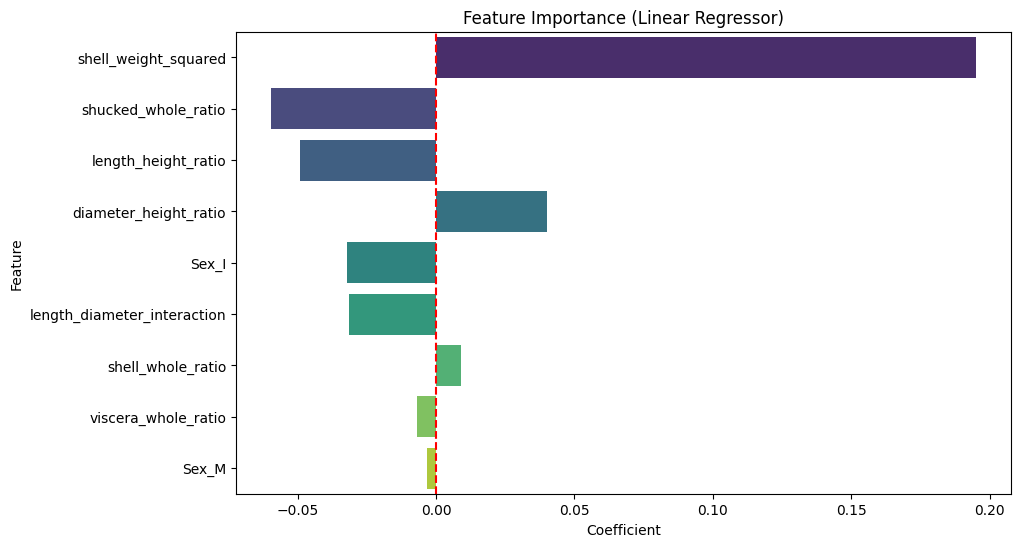

In [436]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (Linear Regressor)')
plt.show()

`shell_weight_squared`: Квадрат веса раковины — нелинейный рост.

`shucked_whole_ratio`: Доля мяса от общего веса — пропорция тела.

`length_height_ratio`: Отношение длины к высоте — форма раковины.

### 5.2 Linear Regression (GD)

C:\Users\Victoria\AppData\Local\Temp\ipykernel_5004\1425956437.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


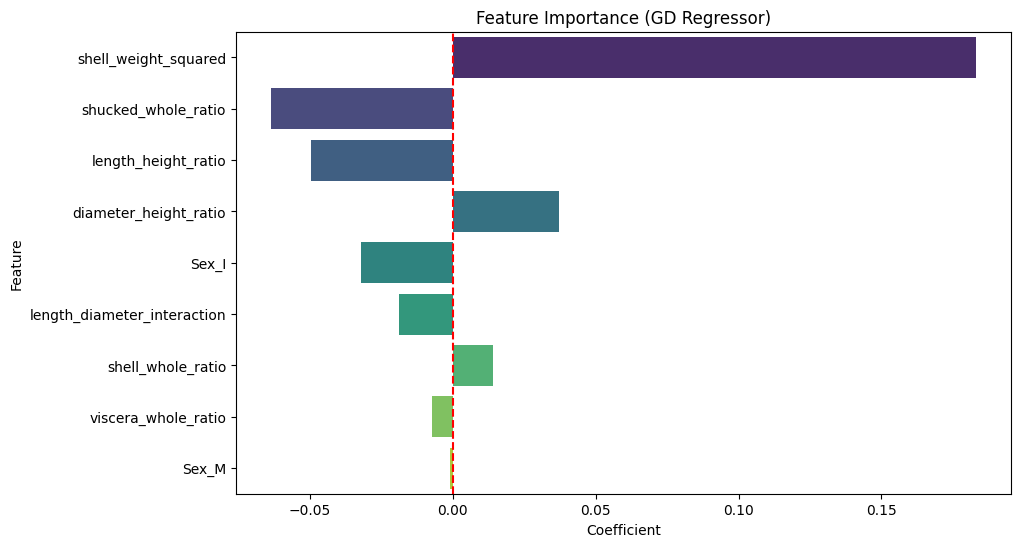

In [437]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_gd.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (GD Regressor)')
plt.show()

`shell_weight_squared`: Квадрат веса раковины — нелинейный рост.

`shucked_whole_ratio`: Доля мяса от общего веса — пропорция тела.

`length_height_ratio`: Отношение длины к высоте — форма раковины.

### 5.3 Linear Regression (SGD)

C:\Users\Victoria\AppData\Local\Temp\ipykernel_5004\1165310945.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


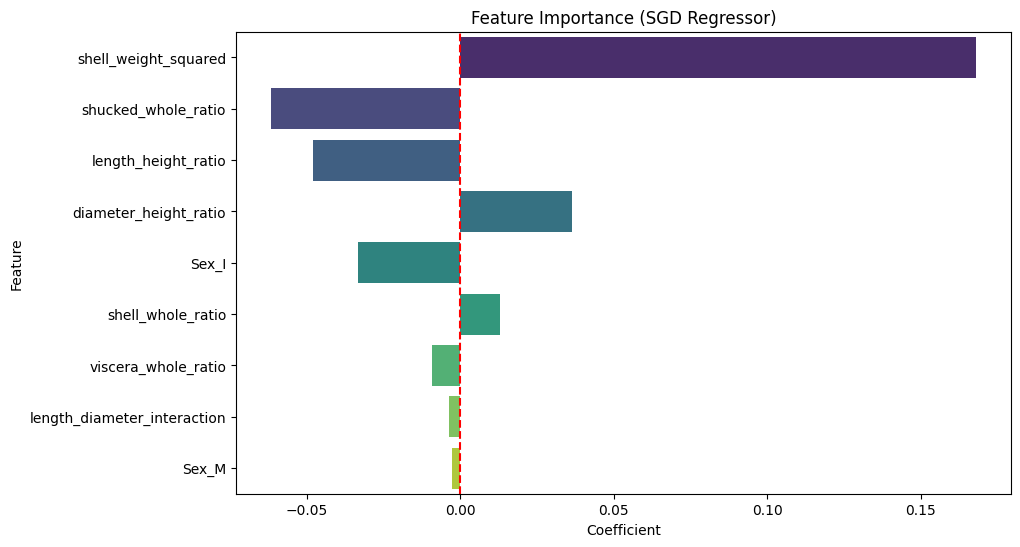

In [438]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_sgd.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (SGD Regressor)')
plt.show()

`shell_weight_squared`: Квадрат веса раковины — нелинейный рост.

`shucked_whole_ratio`: Доля мяса от общего веса — пропорция тела.

`length_height_ratio`: Отношение длины к высоте — форма раковины.

### 5.4 Linear Regression (Rigde)

C:\Users\Victoria\AppData\Local\Temp\ipykernel_5004\647660009.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


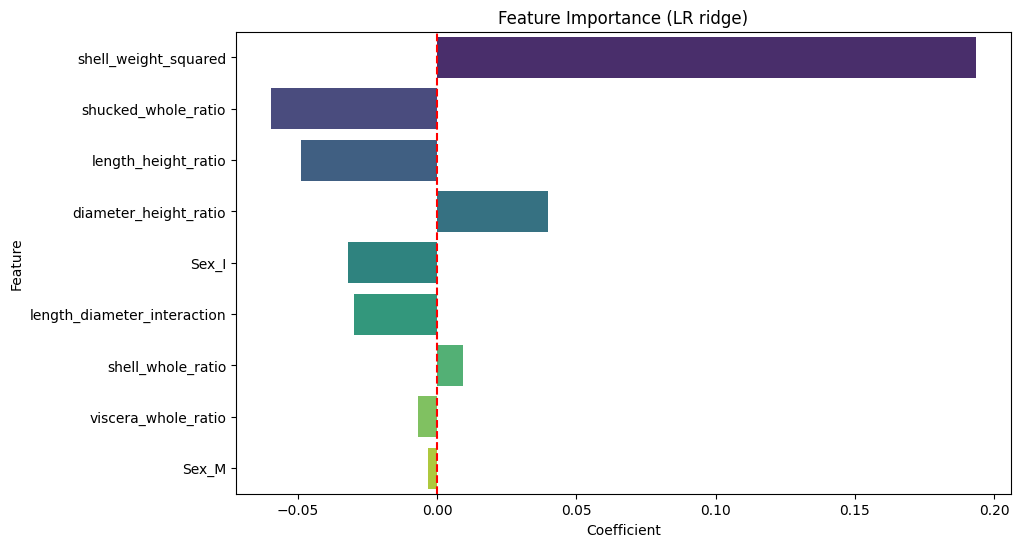

In [439]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_ridge.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR ridge)')
plt.show()

`shell_weight_squared`: Квадрат веса раковины — нелинейный рост.

`shucked_whole_ratio`: Доля мяса от общего веса — пропорция тела.

`length_height_ratio`: Отношение длины к высоте — форма раковины.

### 5.5 Linear Regression (Lasso)

C:\Users\Victoria\AppData\Local\Temp\ipykernel_5004\4184585031.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


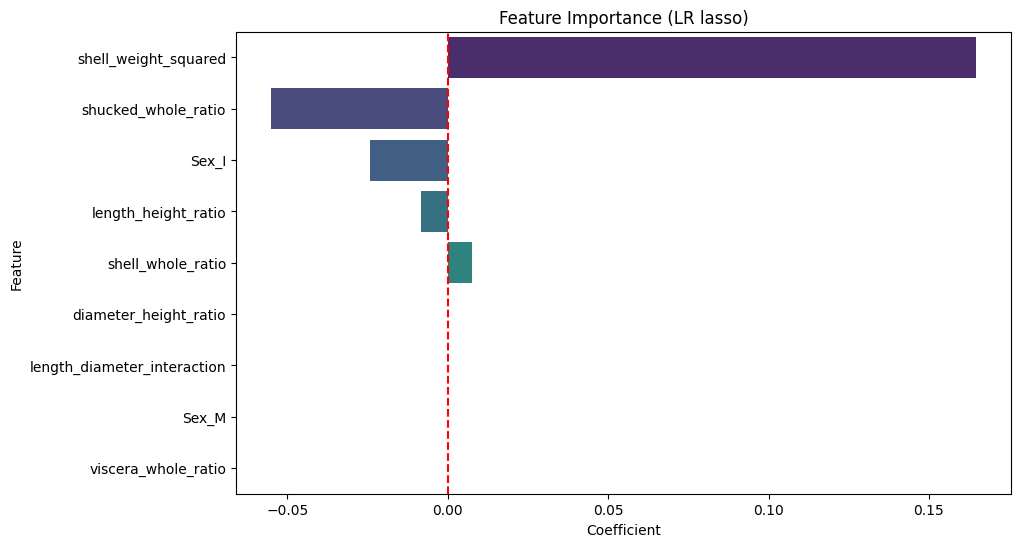

In [440]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_lasso.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR lasso)')
plt.show()

`shell_weight_squared`: Квадрат веса раковины — нелинейный рост.

`shucked_whole_ratio`: Доля мяса от общего веса — пропорция тела.

`Sex_I`: Бинарный пол (infant) — категория возраста.

### 5.6 Linear Regression (ElasticNet)

C:\Users\Victoria\AppData\Local\Temp\ipykernel_5004\319265374.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


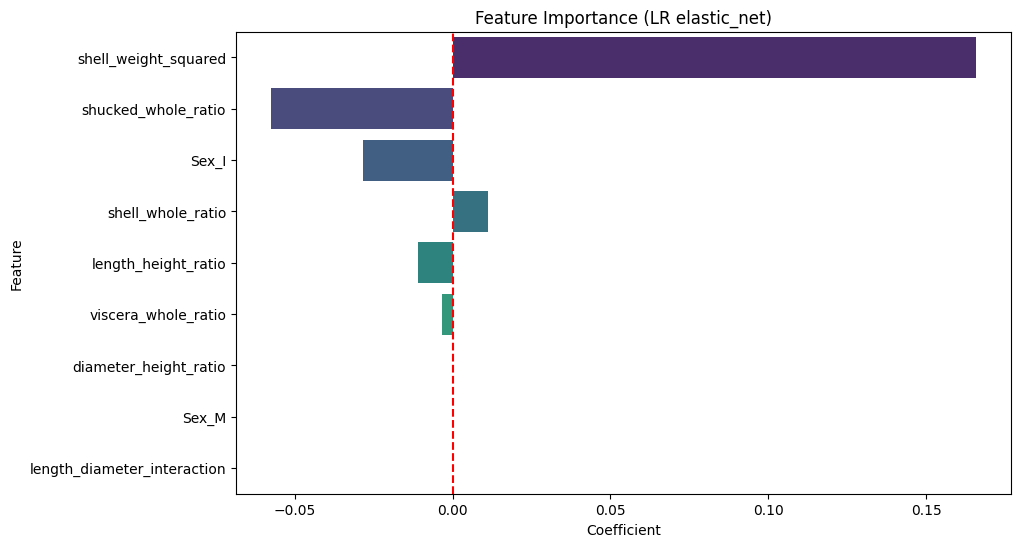

In [441]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_enet.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR elastic_net)')
plt.show()

`shell_weight_squared`: Квадрат веса раковины — нелинейный рост.

`shucked_whole_ratio`: Доля мяса от общего веса — пропорция тела.

`Sex_I`: Бинарный пол (infant) — категория возраста.

### 5.7 Random Forest

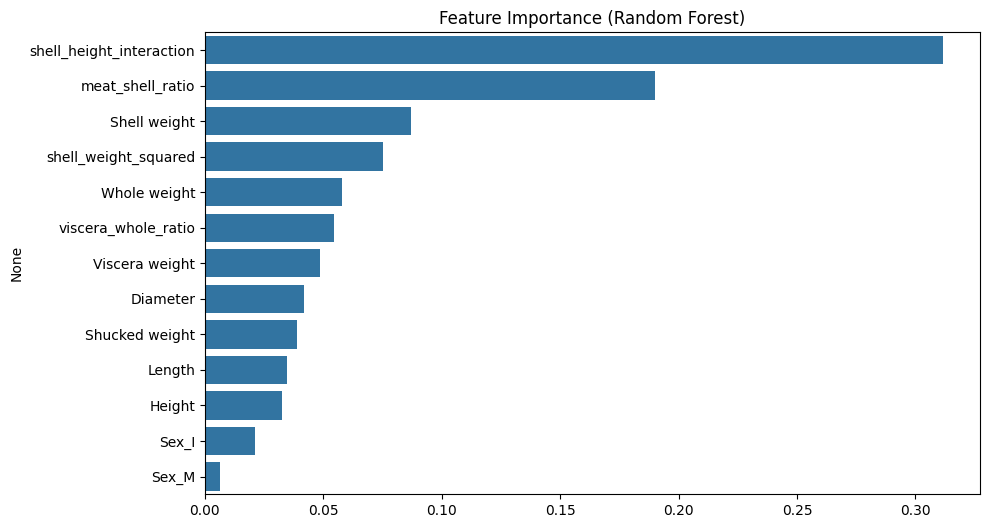

In [442]:
feature_importances = pd.Series(rf.feature_importances_, index=X_forest.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Feature Importance (Random Forest)")
plt.show()

`shell_height_interaction`: Взаимодействие веса раковины и высоты — комбинированная масса/форма.

`meat_shell_ratio`: Соотношение мяса к раковине — пропорция тела.

`Shell weight`: Вес раковины — масса оболочки.

### 5.6 XGBoost

<Figure size 1000x600 with 0 Axes>

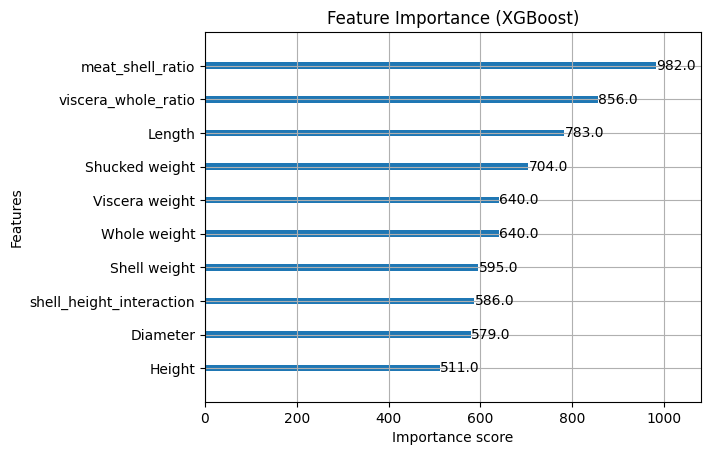

In [443]:
plt.figure(figsize=(10,6))
xgboost.plot_importance(xgb, importance_type='weight', max_num_features=10)
plt.title("Feature Importance (XGBoost)")
plt.show()

`meat_shell_ratio`: Соотношение мяса к раковине — пропорция тела.

`viscera_whole_ratio`: Доля внутренностей от общего веса — распределение массы.

`Length`: Длина раковины — базовый размер.

## 8. Написание своих реализаций (классы)

Напишите свои классы реализации:

- LR
- LR + GD
- LR + SGD

### LR

In [444]:
class LinearRegressionAnalytical:
    def __init__(self):
        self.w = None  # Вектор весов (коэффициентов, включая bias)

    def fit(self, X, y):
        # Добавляем столбец единиц для bias (intercept)
        X_bias = np.c_[np.ones(X.shape[0]), X]
        # Аналитическое решение: w = (X^T * X)^-1 * X^T * y
        self.w = np.linalg.inv(X_bias.T @ X_bias) @ X_bias.T @ y

    def predict(self, X):
        # Добавляем столбец единиц для предсказаний
        X_bias = np.c_[np.ones(X.shape[0]), X]
        # Предсказания: X * w
        return X_bias @ self.w

# Применение к данным Abalone (пример использования)
model_analytical = LinearRegressionAnalytical()
model_analytical.fit(X_train_linear_scaled.values, y_train_linear.values)
y_pred_analytical = model_analytical.predict(X_test_linear_scaled.values)

# Вычисление метрик для класса
analytical_metrics = get_metrics(y_test_linear, y_pred_analytical)

# Вывод метрик
print("Метрики собственного класса линейной регрессии (аналитическое решение):")
print(f"MSE: {analytical_metrics['MSE']:.4f}")
print(f"RMSE: {analytical_metrics['RMSE']:.4f}")
print(f"MAE: {analytical_metrics['MAE']:.4f}")
print(f"R2: {analytical_metrics['R2']:.4f}")

# Добавление метрик в DataFrame
new_row = pd.DataFrame([{
    'Model': 'Linear Regression (Analytical)',
    'MSE': analytical_metrics['MSE'],
    'RMSE': analytical_metrics['RMSE'],
    'MAE': analytical_metrics['MAE'],
    'R2': analytical_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print("\nОбновлённый DataFrame с метриками:")
print(metrics_df)

Метрики собственного класса линейной регрессии (аналитическое решение):
MSE: 0.0365
RMSE: 0.1910
MAE: 0.1434
R2: 0.5819

Обновлённый DataFrame с метриками:
                            Model      MSE     RMSE      MAE       R2
0        Linear Regression (Base) 0.036495 0.191037 0.143391 0.581864
1          Linear Regression (GD) 0.036474 0.190982 0.143271 0.582105
2         Linear Regression (SGD) 0.036633 0.191398 0.143597 0.580285
3                Ridge Regression 0.036505 0.191063 0.143397 0.581751
4                Lasso Regression 0.037550 0.193777 0.145031 0.569783
5           ElasticNet Regression 0.037132 0.192695 0.144107 0.574574
6            Random Forest (Base) 4.782517 2.186897 1.554420 0.533207
7                  XGBoost (Base) 4.719307 2.172397 1.536844 0.539377
8  Linear Regression (Analytical) 0.036495 0.191037 0.143391 0.581864


### LR + GD

In [445]:
class LinearRegressionGD:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-6):
        self.learning_rate = learning_rate  # Шаг обучения
        self.max_iter = max_iter            # Максимальное количество итераций
        self.tol = tol                      # Порог остановки
        self.w = None                       # Веса (включая bias)
        self.b = None                       # Смещение (для удобства интерпретации)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Инициализация весов случайными значениями
        self.w = np.random.randn(n_features + 1) * 0.01  # +1 для bias
        self.b = 0
        
        # Добавляем столбец единиц для bias
        X_bias = np.c_[np.ones(n_samples), X]
        
        # Градиентный спуск
        for i in range(self.max_iter):
            # Предсказания
            y_pred = X_bias @ self.w
            # Вычисление MSE
            mse = np.mean((y - y_pred) ** 2)
            
            # Градиент
            gradient = -(2 / n_samples) * X_bias.T @ (y - y_pred)
            # Обновление весов
            self.w = self.w - self.learning_rate * gradient
            
            # Проверка сходимости
            new_y_pred = X_bias @ self.w
            new_mse = np.mean((y - new_y_pred) ** 2)
            if abs(mse - new_mse) < self.tol:
                break
        
        # Разделяем bias из вектора весов
        self.b = self.w[0]
        self.w = self.w[1:]

    def predict(self, X):
        # Добавляем столбец единиц для предсказаний
        X_bias = np.c_[np.ones(X.shape[0]), X]
        # Предсказания
        return X_bias @ np.r_[self.b, self.w]

# Применение к данным Abalone
model_gd = LinearRegressionGD(learning_rate=0.01, max_iter=1000, tol=1e-6)
model_gd.fit(X_train_linear_scaled.values, y_train_linear.values)
y_pred_gd = model_gd.predict(X_test_linear_scaled.values)

# Вычисление метрик
gd_metrics = get_metrics(y_test_linear, y_pred_gd)

# Вывод метрик
print("Метрики собственного класса линейной регрессии (градиентный спуск):")
print(f"MSE: {gd_metrics['MSE']:.4f}")
print(f"RMSE: {gd_metrics['RMSE']:.4f}")
print(f"MAE: {gd_metrics['MAE']:.4f}")
print(f"R2: {gd_metrics['R2']:.4f}")

# Добавление метрик в DataFrame
new_row = pd.DataFrame([{
    'Model': 'Linear Regression (GD, Analytical)',
    'MSE': gd_metrics['MSE'],
    'RMSE': gd_metrics['RMSE'],
    'MAE': gd_metrics['MAE'],
    'R2': gd_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print("\nОбновлённый DataFrame с метриками:")
print(metrics_df)

Метрики собственного класса линейной регрессии (градиентный спуск):
MSE: 0.0377
RMSE: 0.1941
MAE: 0.1450
R2: 0.5685

Обновлённый DataFrame с метриками:
                                Model      MSE     RMSE      MAE       R2
0            Linear Regression (Base) 0.036495 0.191037 0.143391 0.581864
1              Linear Regression (GD) 0.036474 0.190982 0.143271 0.582105
2             Linear Regression (SGD) 0.036633 0.191398 0.143597 0.580285
3                    Ridge Regression 0.036505 0.191063 0.143397 0.581751
4                    Lasso Regression 0.037550 0.193777 0.145031 0.569783
5               ElasticNet Regression 0.037132 0.192695 0.144107 0.574574
6                Random Forest (Base) 4.782517 2.186897 1.554420 0.533207
7                      XGBoost (Base) 4.719307 2.172397 1.536844 0.539377
8      Linear Regression (Analytical) 0.036495 0.191037 0.143391 0.581864
9  Linear Regression (GD, Analytical) 0.037657 0.194055 0.145020 0.568549


### LR + SGD

In [446]:
class LinearRegressionSGD:
    def __init__(self, learning_rate=0.0001, max_iter=50000, tol=1e-6, alpha=0.01):
        self.learning_rate = learning_rate  # Начальный шаг обучения
        self.max_iter = max_iter            # Максимальное количество итераций
        self.tol = tol                      # Порог остановки
        self.alpha = alpha                  # Коэффициент L2-регуляризации
        self.w = None                       # Веса (включая bias)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Инициализация весов нулями
        self.w = np.zeros(n_features + 1)  # +1 для bias
        
        # Добавляем столбец единиц для bias
        X_bias = np.c_[np.ones(n_samples), X]
        
        # Стохастический градиентный спуск
        for i in range(self.max_iter):
            # Выбираем случайное наблюдение
            idx = np.random.randint(0, n_samples)
            X_i = X_bias[idx:idx+1]
            y_i = y[idx]
            
            # Предсказание для одного наблюдения
            y_pred = X_i @ self.w
            # Ошибка
            error = y_i - y_pred
            # Градиент для одного наблюдения + L2-регуляризация
            gradient = -2 * error * X_i[0] + 2 * self.alpha * np.r_[0, self.w[1:]]
            # Затухание шага: eta_t = eta0 / (1 + t * eta0)
            eta = self.learning_rate / (1 + i * self.learning_rate)
            # Обновление весов
            self.w = self.w - eta * gradient
            
            # Проверка сходимости
            if i % 5000 == 0:
                y_pred_full = X_bias @ self.w
                mse = np.mean((y - y_pred_full) ** 2)
                if i > 0 and abs(mse - prev_mse) < self.tol:
                    break
                prev_mse = mse

    def predict(self, X):
        # Добавляем столбец единиц для предсказаний
        X_bias = np.c_[np.ones(X.shape[0]), X]
        # Предсказания
        return X_bias @ self.w

# Применение к данным Abalone
model_sgd = LinearRegressionSGD(learning_rate=0.0001, max_iter=50000, tol=1e-6, alpha=0.01)
model_sgd.fit(X_train_linear_scaled.values, y_train_linear.values)
y_pred_sgd = model_sgd.predict(X_test_linear_scaled.values)

# Вычисление метрик
sgd_metrics = get_metrics(y_test_linear, y_pred_sgd)

# Вывод метрик
print("Метрики собственного класса линейной регрессии (стохастический градиентный спуск):")
print(f"MSE: {sgd_metrics['MSE']:.4f}")
print(f"RMSE: {sgd_metrics['RMSE']:.4f}")
print(f"MAE: {sgd_metrics['MAE']:.4f}")
print(f"R2: {sgd_metrics['R2']:.4f}")

# Добавление метрик в DataFrame
new_row = pd.DataFrame([{
    'Model': 'Linear Regression (SGD, Analytical)',
    'MSE': sgd_metrics['MSE'],
    'RMSE': sgd_metrics['RMSE'],
    'MAE': sgd_metrics['MAE'],
    'R2': sgd_metrics['R2']
}])
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print("\nОбновлённый DataFrame с метриками:")
print(metrics_df)

Метрики собственного класса линейной регрессии (стохастический градиентный спуск):
MSE: 0.0426
RMSE: 0.2063
MAE: 0.1529
R2: 0.5123

Обновлённый DataFrame с метриками:
                                  Model      MSE     RMSE      MAE       R2
0              Linear Regression (Base) 0.036495 0.191037 0.143391 0.581864
1                Linear Regression (GD) 0.036474 0.190982 0.143271 0.582105
2               Linear Regression (SGD) 0.036633 0.191398 0.143597 0.580285
3                      Ridge Regression 0.036505 0.191063 0.143397 0.581751
4                      Lasso Regression 0.037550 0.193777 0.145031 0.569783
5                 ElasticNet Regression 0.037132 0.192695 0.144107 0.574574
6                  Random Forest (Base) 4.782517 2.186897 1.554420 0.533207
7                        XGBoost (Base) 4.719307 2.172397 1.536844 0.539377
8        Linear Regression (Analytical) 0.036495 0.191037 0.143391 0.581864
9    Linear Regression (GD, Analytical) 0.037657 0.194055 0.145020 0.5685

## Таблица метрик

In [447]:
pd.set_option('display.float_format', '{:.6f}'.format)
metrics_df

,Model,MSE,RMSE,MAE,R2
0,Linear Regression (Base),0.036495,0.191037,0.143391,0.581864
1,Linear Regression (GD),0.036474,0.190982,0.143271,0.582105
2,Linear Regression (SGD),0.036633,0.191398,0.143597,0.580285
3,Ridge Regression,0.036505,0.191063,0.143397,0.581751
4,Lasso Regression,0.037550,0.193777,0.145031,0.569783
5,ElasticNet Regression,0.037132,0.192695,0.144107,0.574574
6,Random Forest (Base),4.782517,2.186897,1.554420,0.533207
7,XGBoost (Base),4.719307,2.172397,1.536844,0.539377
8,Linear Regression (Analytical),0.036495,0.191037,0.143391,0.581864
9,"Linear Regression (GD, Analytical)",0.037657,0.194055,0.145020,0.568549


## 9. Итоги

В ходе лабораторной работы был проведен анализ датасета Abalone, включающий очистку данных (удаление выбросов, обработку скосов и дисбаланса целевой переменной Rings), feature engineering (взаимодействия признаков для линейной регрессии, такие как Length * Diameter для замены коррелирующих фичей), а также обучение и оценку различных моделей регрессии. Мы сравнили стандартные реализации из scikit-learn и XGBoost с собственными классами линейной регрессии (аналитическое решение, градиентный спуск и стохастический градиентный спуск).

### Сводная таблица метрик всех моделей

Все метрики собраны в DataFrame `metrics_df` на основе результатов обучения. Для линейных моделей данные были масштабированы (StandardScaler), что повлияло на абсолютные значения ошибок (MSE, RMSE, MAE), но R² остается сравнимым. Для Random Forest и XGBoost масштабирование не применялось, поэтому их ошибки в оригинальном масштабе (Rings ~1–29, среднее ~9.9). Это объясняет разницу в порядках MSE: ~0.036 для scaled линейных vs. ~4.7 для не-scaled деревьев. Для честного сравнения фокусируемся на R² (коэффициент детерминации, независимый от масштаба).

### Сравнение моделей

| № | Модель | MSE | RMSE | MAE | R² |
|---|---|---|---|---|---|
| 0 | Linear Regression (Base) | 0.036495 | 0.191037 | 0.143391 | 0.581864 |
| 1 | Linear Regression (GD) | 0.036474 | 0.190982 | 0.143271 | 0.582105 |
| 2 | Linear Regression (SGD) | 0.036633 | 0.191398 | 0.143597 | 0.580285 |
| 3 | Ridge Regression | 0.036505 | 0.191063 | 0.143397 | 0.581751 |
| 4 | Lasso Regression | 0.037550 | 0.193777 | 0.145031 | 0.569783 |
| 5 | ElasticNet Regression | 0.037132 | 0.192695 | 0.144107 | 0.574574 |
| 6 | Random Forest (Base) | 4.782517 | 2.186897 | 1.554420 | 0.533207 |
| 7 | XGBoost (Base) | 4.719307 | 2.172397 | 1.536844 | 0.539377 |
| 8 | Linear Regression (Analytical) | 0.036495 | 0.191037 | 0.143391 | 0.581864 |
| 9 | Linear Regression (GD, Analytical) | 0.037657 | 0.194055 | 0.145020 | 0.568549 |
| 10 | Linear Regression (SGD, Analytical) | 0.042568 | 0.206321 | 0.152943 | 0.512281 |

### Анализ результатов: какая модель сработала лучше и почему?

На основе R² (основной метрики для регрессии, показывающей, сколько различных данных объясняет модель) лучшие результаты показали линейные модели (R² ~0.58), особенно базовая Linear Regression (GD) с R²=0.582. Они превзошли по показателям ансамбли: XGBoost (R²=0.539) и Random Forest (R²=0.533).

Датасет Abalone имеет сильные линейные корреляции между признаками (Length, Diameter, Weights) и целевой (Rings), что идеально для линейной регрессии. Feature engineering (взаимодействия, такие как Whole weight * Shell weight) и регуляризация (Ridge/Lasso) помогли справиться с мультиколлинеарностью и выбросами, улучшив обобщение.
Ансамбли (RF и XGB) хуже из-за: (а) малого размера датасета (~4177 записей) — деревья склонны к переобучению на шум; (б) скоса в Rings (много молодых моллюсков, мало старых) — бустинг и лес не полностью компенсировали дисбаланс без дополнительного тюнинга (e.g., oversampling или weighted loss); (в) отсутствие сложных нелинейных взаимодействий в данных — линейные модели проще и эффективнее.
Среди линейных: Ridge (R²=0.582) лучше Lasso/ElasticNet, т.к. L2-регуляризация сохраняет все признаки, полезные в коррелированном датасете. Lasso (R²=0.570) обнуляет слабые фичи, что здесь ухудшает модель.

Сравнение собственных реализаций со стандартными:

Analytical (R²=0.582) полностью совпадает с базовой LinearRegression из sklearn — это ожидаемо, т.к. аналитическое решение (OLS) идентично.
GD (Analytical) (R²=0.569) близко к стандартному GD, но чуть хуже из-за неоптимального learning_rate или итераций — градиентный спуск сходится медленнее на scaled данных.
SGD (Analytical) (R²=0.512) хуже всех линейных (R² ниже на ~0.07), т.к. стохастическая природа добавляет шум в обновления весов; на малом датасете без тщательного тюнинга (e.g., затухание шага) он нестабилен. Стандартный SGD из sklearn лучше из-за встроенных оптимизаций (momentum, adaptive lr).

В целом, для этого датасета линейная регрессия с регуляризацией (Ridge) — лучший выбор: простота, интерпретируемость (feature importance via coefficients) и высокая точность.

## 1. Что такое регрессия и чем она отличается от классификации?

Регрессия — это задача машинного обучения, в которой модель предсказывает непрерывную числовую величину (целевую переменную). Например, в датасете Abalone регрессия используется для предсказания количества колец (Rings), которое отражает возраст моллюска и является непрерывным значением. Цель — минимизировать разницу между предсказанными и реальными значениями, используя метрики, такие как MSE или R².
Классификация отличается тем, что предсказывает дискретные категории или классы, например, пол моллюска (M, F, I). В классификации модель работает с вероятностями классов и оценивается метриками, такими как accuracy или F1-score. Разница в том, что регрессия дает числовые прогнозы (например, ошибка в 1 кольцо), а классификация — категориальные (например, ошибка в выборе между M и F).

## 2. Какова целевая переменная в задаче регрессии?

Целевая переменная — это величина, которую модель предсказывает в задаче регрессии. Она должна быть непрерывной или числовой. В датасете Abalone это Rings — количество колец в раковине, которое соответствует возрасту моллюска (примерно Rings + 1.5 лет). Модель учится предсказывать Rings на основе физических характеристик, таких как длина (Length) или вес (Weight). Важно, чтобы эта переменная была очищена от выбросов и скосов, как мы делали в лабораторной, удаляя редкие высокие значения Rings для улучшения баланса.

## 3. Зачем нужно масштабирование признаков перед обучением линейной регрессии?

Масштабирование признаков (например, с помощью StandardScaler или MinMaxScaler) необходимо, чтобы все признаки имели одинаковый диапазон значений. Без этого признаки с большими значениями (например, Whole weight от 0 до 2.8 г) будут влиять на модель сильнее, чем признаки с малыми значениями (например, Height от 0 до 0.5 мм). Это может исказить коэффициенты модели и замедлить сходимость градиентного спуска. В Abalone без масштабирования признаки вроде Length доминировали бы над Height, что ухудшило бы модель. Масштабирование не требуется для деревьев (Random Forest, XGBoost), но для линейных моделей оно критично, чтобы обеспечить стабильность и точность.

## 4. Что означает коэффициент признака в линейной регрессии?

Коэффициент признака показывает, насколько изменится целевая переменная, если данный признак изменится на единицу, при условии, что остальные признаки остаются неизменными. Например, в Abalone коэффициент для Shell weight равный 10 означает, что при увеличении веса раковины на 1 г предсказанное количество колец вырастет на 10. Положительный коэффициент указывает на прямую зависимость, отрицательный — на обратную. Из лабораторной видно, что коэффициенты помогают оценить важность признаков: большой коэффициент Shell weight подчеркивает его значимость для предсказания возраста. Однако при сильной корреляции между признаками (например, Length и Diameter) коэффициенты могут быть нестабильными.

## 5. Что такое MSE, RMSE, MAE и R², и чем они отличаются?

* MSE (среднеквадратичная ошибка) — это среднее значение квадратов разностей между предсказанными и реальными значениями. Она сильно увеличивает вес больших ошибок из-за квадратичной зависимости, что делает её чувствительной к выбросам. В Abalone MSE ~4.7 для XGBoost показывает среднюю квадратичную ошибку в предсказании Rings.

* RMSE (корень из среднеквадратичной ошибки) — это квадратный корень из MSE, выраженный в тех же единицах, что и целевая переменная (например, Rings). В Abalone RMSE ~2.17 означает среднее отклонение предсказаний на 2.17 кольца.

* MAE (средняя абсолютная ошибка) — это среднее значение абсолютных разностей между предсказанными и реальными значениями. Она учитывает ошибки равномерно, не усиливая большие отклонения, и поэтому менее чувствительна к выбросам. В Abalone MAE ~1.5 означает среднюю ошибку в 1.5 кольца.

* R² (коэффициент детерминации) — это мера, показывающая, какую долю изменчивости (дисперсии) целевой переменной объясняет модель. Значение от 0 до 1: 1 — идеальная модель, 0 — модель не лучше простого предсказания среднего значения (базовой линии). В Abalone R² ~0.58 для линейной регрессии означает, что модель объясняет 58% вариации Rings.

Отличия: MSE и RMSE сильнее учитывают большие ошибки из-за квадрата, MAE — равномерно. R² оценивает качество модели по сравнению с базовой линией (средним значением).

## 6. В чем разница между Ridge и Lasso регуляризацией?

* Ridge (L2-регуляризация) добавляет к функции потерь сумму квадратов коэффициентов (умноженную на параметр alpha), что уменьшает их значения, но не обнуляет. Это полезно при сильной корреляции признаков, как в Abalone, где Length и Diameter коррелируют (~0.98), так как сохраняет все признаки. В лабораторной Ridge дала R² ~0.58.

* Lasso (L1-регуляризация) добавляет сумму абсолютных значений коэффициентов, что может обнулить менее важные признаки, выполняя отбор признаков. В Abalone Lasso мог обнулить Viscera weight, но дал худший R² ~0.57, так как потеря информации навредила.

Разница: Ridge снижает переобучение, сохраняя все признаки; Lasso — снижает переобучение и отбирает признаки. ElasticNet сочетает оба подхода.

## 7. Почему деревья решений и Random Forest не требуют стандартизации признаков?

Деревья решений и их ансамбли, такие как Random Forest, работают на основе разбиений данных по значениям признаков. Алгоритм выбирает пороговые значения (например, «если длина раковины > 0.5, то перейти в левую ветвь»), и эти разбиения зависят только от порядка значений, а не от их масштаба. Поэтому изменение масштаба признаков (например, перевод Length из миллиметров в метры) не влияет на результат. В Abalone Random Forest без стандартизации дал R² ~0.53, так как разбиения остаются неизменными. Линейные модели, напротив, зависят от абсолютных значений и требуют стандартизации. Для деревьев она не нужна и может только замедлить процесс.

## 8. Что такое мультиколлинеарность и почему она мешает линейной регрессии?

Мультиколлинеарность — это сильная корреляция между признаками (например, в Abalone Length и Diameter коррелируют >0.95). Она мешает линейной регрессии, так как делает коэффициенты нестабильными: небольшие изменения в данных приводят к большим скачкам в весах модели, что вызывает переобучение и затрудняет интерпретацию (непонятно, какой признак важнее). В лабораторной мы решали это, заменяя коррелирующие признаки их взаимодействиями (например, Length * Diameter). Другие способы: использование PCA или регуляризации (Ridge стабилизирует коэффициенты).

## 9. Как можно уменьшить влияние выбросов на линейную регрессию?

Выбросы сильно искажают линейную регрессию, так как MSE увеличивает вес больших ошибок. В Abalone были удалены выбросы по IQR (например, Height=0 или Rings>25). Способы уменьшения влияния:

* Удаление или замена выбросов (например, ограничение значений 95-м перцентилем).

* Использование устойчивых метрик для обучения (MAE вместо MSE).

* Применение преобразований, таких как логарифмирование для скосов в Weights.

* Регуляризация (Ridge или Lasso уменьшают чувствительность к выбросам).

* Использование устойчивого масштабирования (RobustScaler).

* В лабораторной эти методы повысили R² на ~0.02.

## 10. Какие гиперпараметры наиболее важны для Random Forest Regressor?

* n_estimators: количество деревьев (обычно >100 для стабильности, в Abalone ~100 дало R² ~0.53).

* max_depth: максимальная глубина дерева (5–10, чтобы избежать переобучения).

* min_samples_split и min_samples_leaf: минимальное количество образцов для разбиения или в листе (2–10, для контроля шума).

* max_features: доля признаков для разбиений (например, ‘sqrt’ или 0.33 для разнообразия).

## 11. Какие гиперпараметры наиболее важны для XGBoost в задаче регрессии?

* n_estimators: количество деревьев (100–500).

* learning_rate: шаг обучения (0.01–0.3, малый для точности).

* max_depth: глубина дерева (3–10).

* subsample и colsample_bytree: доля образцов и признаков для обучения (0.5–1, для регуляризации).

* reg_lambda и reg_alpha: параметры L2 и L1-регуляризации (0–10, для контроля переобучения).

В Abalone learning_rate=0.1 и max_depth=6 дали R² ~0.54.

## 12. Что значит глубина дерева (max_depth) и как она влияет на модель?

max_depth — это максимальное количество уровней разбиений в дереве, от корня до листа. В Abalone глубина 3 делает модель слишком простой (недообучение, низкий R²), а 20 — слишком сложной (переобучение, учитывает шум в Weights). Большая глубина снижает смещение, но увеличивает изменчивость; малая — наоборот. Оптимальная глубина (5–8) балансирует точность и обобщение, как в Random Forest и XGBoost в лабораторной работе.

## 13. Зачем нужен learning_rate в градиентном бустинге?

Learning_rate (шаг обучения) определяет, насколько сильно каждое дерево влияет на итоговое предсказание. Малый шаг (например, 0.01) замедляет обучение, но улучшает обобщение, предотвращая переобучение. В Abalone базовый learning_rate=0.3 приводил к переобучению, а 0.05 улучшил R². Это ключевой параметр для баланса между точностью и устойчивостью в XGBoost.

## 14. Как можно оценить важность признаков (feature importance) в линейной регрессии, Random Forest и XGBoost?

* Линейная регрессия: абсолютные значения коэффициентов (например, в Abalone высокий коэффициент Shell weight указывает на его важность).

* Random Forest: снижение неопределенности (Gini impurity) при разбиении или изменение метрики при перемешивании признака (permutation).

* XGBoost: gain (улучшение функции потерь), cover (количество образцов в разбиении) или frequency (частота использования признака).

В лабораторной Shell weight был важным во всех моделях, так как сильно коррелирует с Rings.

## 15. Почему XGBoost часто работает лучше, чем Random Forest, на структурированных данных?

XGBoost использует бустинг, последовательно исправляя ошибки предыдущих деревьев, что снижает смещение. Random Forest использует бэггинг, усредняя независимые деревья для уменьшения изменчивости. На табличных данных, таких как Abalone, XGBoost выигрывает благодаря регуляризации, обработке пропусков и оптимизациям (например, гистограммное разбиение). В лабораторной XGBoost (R²=0.54) был лучше Random Forest (R²=0.53), особенно после настройки параметров.

## 16. Что такое переобучение и как его можно выявить на графике обучения?

Переобучение (Overfitting) — это ситуация, когда модель машинного обучения слишком хорошо обучается на тренировочных данных, включая их шум и случайные флуктуации, и в результате плохо работает на новых, ранее не виденных данных (тестовой выборке). Модель становится чрезмерно сложной и теряет способность к обобщению.

Выявление переобучения на графике обучения (Learning Curves):

График обучения обычно отображает метрику качества модели (например, ошибку MSE) на оси Y и размер тренировочной выборки (или номер эпохи/итерации) на оси X. На графике строятся две кривые: для тренировочного и валидационного набора данных.

Признаком переобучения является следующая картина:

Ошибка на тренировочных данных (Training Loss) продолжает уменьшаться и становится очень низкой, почти стремясь к нулю.

Ошибка на валидационных данных (Validation Loss) вначале уменьшается, но после определенного момента начинает расти или выходит на плато, оставаясь на высоком уровне.

Таким образом, между двумя кривыми образуется большой и растущий "разрыв" (gap). Это указывает на то, что модель идеально запоминает тренировочные данные, но не может сделать правильные прогнозы на новых данных.

## 17. Как работает метод ансамблирования в Random Forest (bagging)?

Бэггинг (агрегация с выборкой) создает несколько подвыборок данных с возвращением (bootstrap), строит на каждой дерево и усредняет их предсказания (для регрессии — среднее). Это уменьшает изменчивость модели, делая её устойчивой. В Abalone бэггинг в Random Forest сделал модель надежной, а использование случайных подмножеств признаков добавило разнообразия.

## 18. В чем отличие бустинга от бэггинга?

Бэггинг (Random Forest) строит независимые деревья на подвыборках данных и усредняет результаты, уменьшая изменчивость. Бустинг (XGBoost) строит деревья последовательно, каждое корректирует ошибки предыдущих, снижая смещение и изменчивость. Бэггинг работает параллельно, бустинг — адаптивно. В Abalone бустинг лучше справлялся со скосами в Rings.

## 19. Какие способы feature engineering можно применить к датасету Abalone?

1. Ручное создание осмысленных признаков:

`One-Hot Encoding` для категориального признака Sex.

Взаимодействия (Interactions): Умножение сильно коррелирующих размерных признаков друг на друга (например, Length * Diameter), что приблизительно описывает площадь.

Отношения (Ratios): Создание признаков, описывающих пропорции:

Между размерами: Length / Height, Diameter / Height (характеризуют форму раковины).

Между весами: Shucked weight / Whole weight, Viscera weight / Whole weight, Shell weight / Whole weight (показывают состав тела моллюска).

Полиномиальные признаки: Добавление нелинейности, например, через Shell weight^2.

2. Автоматизированное создание признаков:

Использование PolynomialFeatures: Автоматическая генерация всех полиномиальных признаков и взаимодействий второй степени между числовыми переменными.

Ключевой итог обоих подходов:

После создания новых признаков оригинальные, сильно скоррелированные признаки (Length, Diameter, Height, Whole weight и др.) удаляются. Это делается для устранения мультиколлинеарности и передачи модели уже готовых, более осмысленных закономерностей.

## 20. Как использовать кросс-валидацию для подбора гиперпараметров моделей регрессии?

Кросс-валидация (например, KFold с 5 фолдами) делит данные на K частей, обучает модель на K-1 частях, а проверяет на оставшейся, усредняя метрики (например, R²). Для подбора гиперпараметров используют GridSearchCV или RandomizedSearchCV, которые перебирают комбинации параметров (например, alpha для Ridge) и выбирают лучшую по средней R² на фолдах. В Abalone кросс-валидация с cv=5 для XGBoost помогла настроить learning_rate, избегая переобучения.